In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

import scipy.optimize as optimization

In [2]:
class MarkowitzModel:
    def __init__(self, stocks, start_date, end_date):
        self.stocks = stocks.copy()
        self.start_date = start_date
        self.end_date = end_date
        # self.dataset = None

        # Пусть будет 100% в год (хотим удвоить).  
        # x^365 = 2, x - доходность акций
        # x = 1.00190084
        # Берём логарифм. ln(x) = 0.000824740721
        # Модель заменяет её сложную динамику на линейную модель. То есть берёём вместо x среднюю доходность и делаем вид, что она постоянно такая
        # self.DOHOD = 0.000824740721
        self.DOHOD = 0.015 # 0.0015
    
    def download_data(self, stdate, endate):
        # df = {}
        # for stock in self.stocks:
        #     ticker = yf.Ticker(stock)
        #     df[stock] = ticker.history(start = self.start_date, end = self.end_date, period='1mo')['Close']
        # return pd.DataFrame(df)
        stock_data = yf.download(self.stocks, start = stdate, end = endate, interval='1mo')
        stock_data = stock_data.dropna()
        return stock_data
    
    def show_data(self, data):
        plt.figure(figsize = (18,6))
        plt.grid(True)
        # plt.xlabel('Expected Volatility')
        # plt.ylabel('Expected Return')
        # plt.colorbar(label = 'Sharp Ratio')
        for stock in self.stocks:
            plt.plot(data['Adj Close'][stock])
        plt.legend(self.stocks, loc='right')
        plt.show()
        # data.plot(figsize = (18,5))
        # plt.show()
        

    def calculate_return(self, data):
        # log_return = np.log(data / data.shift(1))
        # return log_return[1:]
        df = {}
        for stock in self.stocks:
            df[stock] = data['Adj Close'][stock].pct_change()
            
        return pd.DataFrame(df)

    def show_statistics(self, returns):
        #annual return using mean
        print(returns.mean())

        #remember covariance is matrix so it will return that
        print(returns.cov())
    
    def show_mean_variance(self, returns, weights):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        print("Expected portfolio mean(return):", portfolio_return)
        print("Expected portfolio volatility(standart deviation):", portfolio_volatility)

    def generate_portfolios(self, returns):
        portfolio_means = []
        portfolio_risks = []
        portfolio_weights = []

        for i in range(10000):
            w = np.random.random(len(self.stocks))
            w /= np.sum(w)
            portfolio_weights.append(w)
            # returns.mean() -  среднее по одной акции на протяжении всего времени
            portfolio_means.append(np.sum(returns.mean() * w))
            portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov(), w))))

        return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)
    
    def show_portfolios(self, returns, volatilities):
        plt.figure(figsize = (18,6))
        plt.scatter(volatilities, returns, c = returns / volatilities, marker='o')
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.show()

    def statistics(self, weights, returns):
        portfolio_return = np.sum(returns.mean() * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        return np.array([portfolio_return, portfolio_volatility, portfolio_return / portfolio_volatility])

    def min_function_sharp(self, weights, returns):
        return self.statistics(weights, returns)[1]
    
    def optimize_portfolio(self, weights, returns):
        constrains = [
            {
            'type': 'eq',
            'fun': lambda x: np.sum(x) - 1
            },
            {
            'type': 'eq',
            'fun': lambda x, returns: np.sum(returns.mean() * x) - self.DOHOD, # lambda x : np.sum(x) - 1
            'args': (returns,)
            },
        ]
        #the weight can be 1 at most for single stock or weights can have value with in 0 and 1
        bounds = tuple((0, 1) for _ in range(len(self.stocks)))
        return optimization.minimize(
            fun = self.min_function_sharp,
            x0 = weights[0],
            args = returns,
            method = 'SLSQP',
            bounds = bounds,
            constraints = constrains
        )
    
    def print_optimal_portfolio(self, optimum, returns):
        print("Optimal portfolio:", optimum['x'].round(3))
        print("Expected return, volatility and sharp ratio:", self.statistics(optimum['x'].round(3), returns))

    def show_optimal_portfolios(self, opt, rets, portfolio_rets, portfolio_vols):
        plt.figure(figsize = (10,6))
        plt.scatter(
            portfolio_vols,
            portfolio_rets,
            c = portfolio_rets / portfolio_vols,
            marker='o'
        )
        plt.grid(True)
        plt.xlabel('Expected Volatility')
        plt.ylabel('Expected Return')
        plt.colorbar(label = 'Sharp Ratio')
        plt.plot(
            self.statistics(opt['x'], rets)[1],
            self.statistics(opt['x'], rets)[0],
            'g*',
            markersize = 20
        )
        plt.show()

    
    def get_optimal_weights_get_dataset(self, stdate = "", endate = ""):
        if stdate != "" and endate != "":
            self.dataset = self.download_data(stdate, endate)
        elif stdate != "":
            self.dataset = self.download_data(self.start_date, endate)
        else:
            self.dataset = self.download_data(stdate, self.end_date)
    
    # Do all work!
    def get_optimal_weights(self, is_need_graphics = True):
        if is_need_graphics:
            self.show_data(self.dataset)
        log_daily_returns = self.calculate_return(self.dataset)
        # print(log_daily_returns)
        # return
        # return
        #show_statistics(log_daily_returns)

        pweights, means, risks = self.generate_portfolios(log_daily_returns)

        if is_need_graphics:
            self.show_portfolios(means, risks)

        optimum = self.optimize_portfolio(pweights, log_daily_returns)
        self.print_optimal_portfolio(optimum, log_daily_returns)

        if is_need_graphics:
            self.show_optimal_portfolios(optimum, log_daily_returns, means, risks)

        return optimum['x'].round(3)

In [3]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']
start_date = '2014-01-01'
end_date = '2024-01-01'

[*********************100%%**********************]  6 of 6 completed


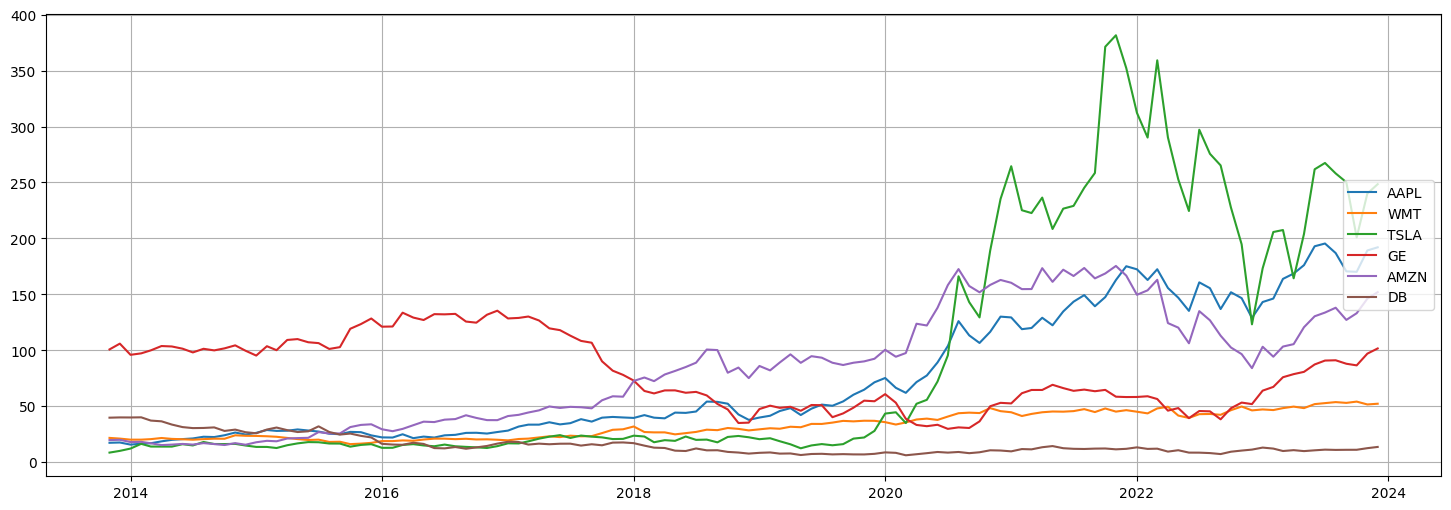

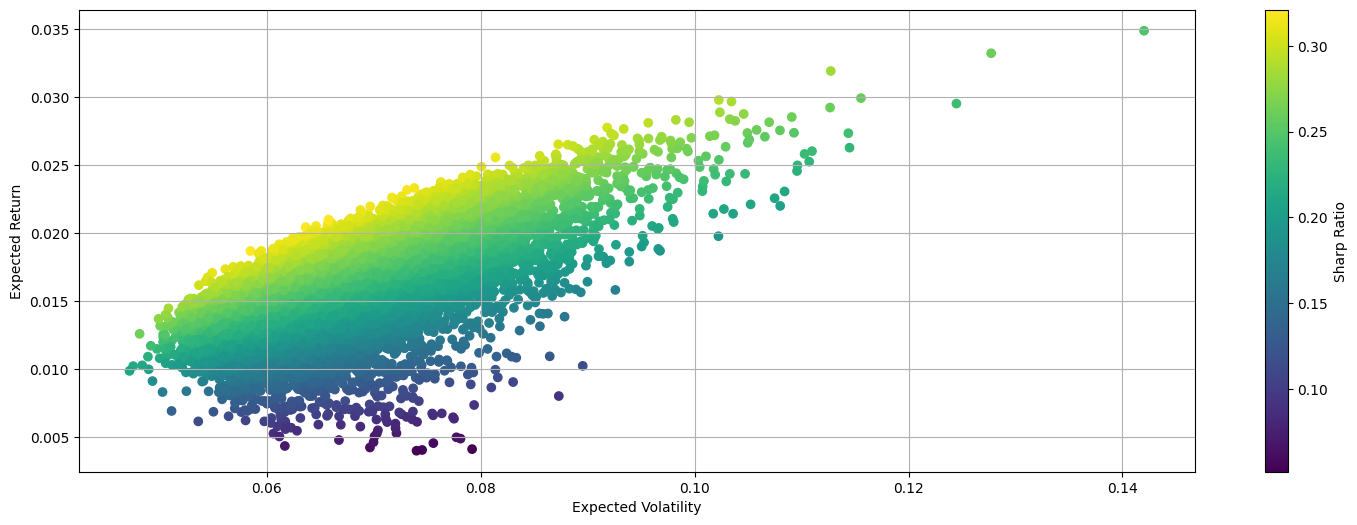

Optimal portfolio: [0.25  0.524 0.029 0.043 0.154 0.   ]
Expected return, volatility and sharp ratio: [0.01501547 0.05020152 0.29910385]


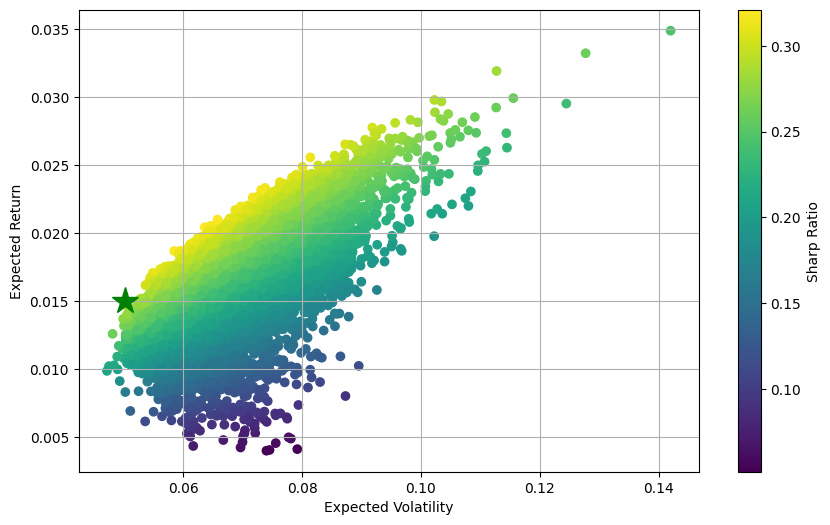

array([0.25 , 0.524, 0.029, 0.043, 0.154, 0.   ])

In [4]:
model = MarkowitzModel(stocks, start_date, end_date)
model.get_optimal_weights_get_dataset('2013-11-01', end_date)
model.get_optimal_weights()

## Попытка в ребалансировку

Смотреть тут: https://readmedium.com/en/https:/python.plainenglish.io/how-to-improve-investment-portfolio-with-rebalancing-strategy-in-python-a58841ee8b5e

In [5]:
stocks = ['AAPL', 'WMT', 'TSLA', 'GE', 'AMZN', 'DB']

In [7]:
stock_data = yf.download(stocks, start='2014-01-01', end='2024-01-01', interval='1mo')
stock_data = stock_data.dropna()

df = {}
for stock in stocks:
    # ticker = yf.Ticker(stock)
    # df[stock] = ticker.history(start = start_date, end = end_date, period='1mo')['Close']
    df[stock] = stock_data['Adj Close'][stock].pct_change()

df = pd.DataFrame(df)
df
# returns = np.log(df / df.shift(1))[1:]
# returns

[*********************100%%**********************]  6 of 6 completed


,AAPL,WMT,TSLA,GE,AMZN,DB
Date,,,,,,
2014-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2014-02-01,0.051218,0.000268,0.349485,0.013530,0.009507,0.003321
2014-03-01,0.026058,0.023159,-0.148523,0.027642,-0.071058,-0.072611
2014-04-01,0.099396,0.049643,-0.002687,0.038625,-0.095847,-0.017845
2014-05-01,0.072718,-0.036884,-0.000577,-0.003719,0.027685,-0.079491
...,...,...,...,...,...,...
2023-08-01,-0.043675,0.017203,-0.034962,0.002854,0.032391,-0.021563
2023-09-01,-0.087448,-0.012985,-0.030456,-0.034160,-0.078907,0.009183
2023-10-01,-0.002570,0.021760,-0.197346,-0.016482,0.046963,0.001820


In [8]:
import datetime
from dateutil.relativedelta import relativedelta
import heapq

In [22]:
def portfolio_without_rebalance(stocks, dataset, numStocks, numRev):
    selected_stocks = stocks.copy()
    returns_array = []
    
    # Будем каждый месяц делать ребалансировку. Стартовая дата - 2018-01-01. Конечная дата - 2024-01-01.
    start_month = 1
    start_year = 2014
    end_month = 1
    end_year = 2024
    curr_datetime = datetime.datetime(start_year, start_month + 1, 1)
    next_datetime = curr_datetime + relativedelta(months=1)
    end_datetime = datetime.datetime(end_year, end_month, 1)

    i = 0
    while next_datetime + relativedelta(months=1) < end_datetime:
        next_datetime = curr_datetime + relativedelta(months=1)

        if len(selected_stocks) > 0:
            # Модель Марковица: считаем оптимальные веса для выбранных акций за месяц
            month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            weights = month_model.get_optimal_weights(is_need_graphics=False)

            values = np.array(weights * df[selected_stocks].iloc[i,:])
#             returns_array.append(np.sum(values))
            returns_array.append(values.mean())
#             indexes_of_max_value = heapq.nsmallest(numRev, range(len(values)), values.take)

#             # убираем numRev наименее доходных акций
#             selected_stocks = [stocks[ind] for ind in range(len(stocks)) if ind not in indexes_of_max_value]
        
#         current_month_returns = np.array(df.iloc[i,:])
#         # Добавляем ещё наиболее доходных акций в количестве numStocks - numRev.
#         # Сортирую в порядке убывания по доходности за месяц
#         indexes_of_max_value = heapq.nlargest(len(stocks), range(len(current_month_returns)), current_month_returns.take)
        
#         # Хотим добавлять только те акции, которых еще нет в selected_stocks
#         for ind in indexes_of_max_value:
#             if stocks[ind] in selected_stocks:
#                 continue
#             if len(selected_stocks) == numStocks:
#                 break
#             selected_stocks.append(stocks[ind])


#         print("From {} to {} was selected {}\n".format(
#             curr_datetime.strftime("%Y-%m-%d"),
#             next_datetime.strftime("%Y-%m-%d"),
#             selected_stocks
#         ))
#         print("\t", weights)
#         print("\t", df[selected_stocks].iloc[i,:])

        i += 1

#         if i > 5:
#             break
        curr_datetime = next_datetime

    # Рассчитываем для финального месяца: просто запускаем Марковица для вычисления весов
    month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    weights = month_model.get_optimal_weights()
    returns = np.array(weights * df[selected_stocks].iloc[i,:])
    # returns_array.append(np.sum(returns))
    returns_array.append(returns.mean())
#     print("-----------------------------------------------------")
#     print("------------------- Final results -------------------")
#     print("Selected stock:", selected_stocks)
#     print("Weights:", weights)
#     print("Returns:", returns)
#     print("-----------------------------------------------------")

    return weights, returns, returns_array

In [23]:
def portfolio(stocks, dataset, numStocks, numRev):
    selected_stocks = stocks.copy()
    returns_array = []
    
    # Будем каждый месяц делать ребалансировку. Стартовая дата - 2018-01-01. Конечная дата - 2024-01-01.
    start_month = 1
    start_year = 2014
    end_month = 1
    end_year = 2024
    curr_datetime = datetime.datetime(start_year, start_month + 1, 1)
    next_datetime = curr_datetime + relativedelta(months=1)
    end_datetime = datetime.datetime(end_year, end_month, 1)

    i = 0
    while next_datetime + relativedelta(months=1) < end_datetime:
        next_datetime = curr_datetime + relativedelta(months=1)

        if len(selected_stocks) > 0:
            # Модель Марковица: считаем оптимальные веса для выбранных акций за месяц
            month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), next_datetime.strftime("%Y-%m-%d"))
            weights = month_model.get_optimal_weights(is_need_graphics=False)

            values = np.array(weights * df[selected_stocks].iloc[i,:])
#             returns_array.append(np.sum(values))
            returns_array.append(values.mean())
            indexes_of_max_value = heapq.nsmallest(numRev, range(len(values)), values.take)

            # убираем numRev наименее доходных акций
            selected_stocks = [stocks[ind] for ind in range(len(stocks)) if ind not in indexes_of_max_value]
        
        current_month_returns = np.array(df.iloc[i,:])
        # Добавляем ещё наиболее доходных акций в количестве numStocks - numRev.
        # Сортирую в порядке убывания по доходности за месяц
        indexes_of_max_value = heapq.nlargest(len(stocks), range(len(current_month_returns)), current_month_returns.take)
        
        # Хотим добавлять только те акции, которых еще нет в selected_stocks
        for ind in indexes_of_max_value:
            if stocks[ind] in selected_stocks:
                continue
            if len(selected_stocks) == numStocks:
                break
            selected_stocks.append(stocks[ind])


        print("From {} to {} was selected {}\n".format(
            curr_datetime.strftime("%Y-%m-%d"),
            next_datetime.strftime("%Y-%m-%d"),
            selected_stocks
        ))
        print("\t", weights)
        print("\t", df[selected_stocks].iloc[i,:])

        i += 1

#         if i > 5:
#             break
        curr_datetime = next_datetime

    # Рассчитываем для финального месяца: просто запускаем Марковица для вычисления весов
    month_model = MarkowitzModel(selected_stocks, curr_datetime.strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    month_model.get_optimal_weights_get_dataset((curr_datetime - relativedelta(months=2)).strftime("%Y-%m-%d"), end_datetime.strftime("%Y-%m-%d"))
    weights = month_model.get_optimal_weights()
    returns = np.array(weights * df[selected_stocks].iloc[i,:])
    # returns_array.append(np.sum(returns))
    returns_array.append(returns.mean())
    print("-----------------------------------------------------")
    print("------------------- Final results -------------------")
    print("Selected stock:", selected_stocks)
    print("Weights:", weights)
    print("Returns:", returns)
    print("-----------------------------------------------------")

    return weights, returns, returns_array

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.   0.   0.05 0.   0.   0.95]
Expected return, volatility and sharp ratio: [0.01487234 0.00814134 1.8267682 ]
From 2014-02-01 to 2014-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.   0.   0.05 0.   0.   0.95]
	 TSLA   NaN
GE     NaN
AMZN   NaN
DB     NaN
Name: 2014-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.006 0.876 0.118 0.   ]
Expected return, volatility and sharp ratio: [1.50050045e-02 9.29072959e-05 1.61505126e+02]
From 2014-03-01 to 2014-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.006 0.876 0.118 0.   ]
	 AAPL    0.051218
WMT     0.000268
AMZN    0.009507
DB      0.003321
Name: 2014-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.821 0.179 0.   ]
Expected return, volatility and sharp ratio: [0.01494754 0.0122373  1.22147384]
From 2014-04-01 to 2014-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.821 0.179 0.   ]
	 WMT     0.023159
GE      0.027642
AMZN   -0.071058
DB     -0.072611
Name: 2014-03-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.952 0.048 0.   ]
Expected return, volatility and sharp ratio: [0.01497948 0.02431131 0.61615284]
From 2014-05-01 to 2014-06-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.952 0.048 0.   ]
	 WMT     0.049643
GE      0.038625
AMZN   -0.095847
DB     -0.017845
Name: 2014-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.411 0.589 0.   ]
Expected return, volatility and sharp ratio: [1.50008248e-02 3.14455079e-04 4.77041898e+01]
From 2014-06-01 to 2014-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.411 0.589 0.   ]
	 TSLA   -0.000577
GE     -0.003719
AMZN    0.027685
DB     -0.079491
Name: 2014-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.328 0.    0.672 0.   ]
Expected return, volatility and sharp ratio: [0.01498811 0.08808051 0.17016379]
From 2014-07-01 to 2014-08-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.328 0.    0.672 0.   ]
	 AAPL    0.033401
TSLA    0.155412
AMZN    0.039130
DB     -0.067352
Name: 2014-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.435 0.    0.    0.565]
Expected return, volatility and sharp ratio: [0.01499712 0.02670076 0.56167374]
From 2014-08-01 to 2014-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.435 0.    0.    0.565]
	 AAPL    0.028732
TSLA   -0.069816
AMZN   -0.036302
DB     -0.028994
Name: 2014-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.242 0.    0.    0.758]
Expected return, volatility and sharp ratio: [0.01499867 0.00819718 1.82973586]
From 2014-09-01 to 2014-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.242 0.    0.    0.758]
	 AAPL    0.072176
GE      0.033002
AMZN    0.083229
DB      0.004391
Name: 2014-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.795 0.    0.    0.205]
Expected return, volatility and sharp ratio: [0.01499527 0.03025764 0.49558623]
From 2014-10-01 to 2014-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.795 0.    0.    0.205]
	 TSLA   -0.100185
GE     -0.013857
AMZN   -0.048962
DB      0.016030
Name: 2014-09-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.392 0.608 0.    0.   ]
Expected return, volatility and sharp ratio: [0.0150068  0.00789877 1.89989042]
From 2014-11-01 to 2014-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.392 0.608 0.    0.   ]
	 WMT    -0.002615
GE      0.018099
AMZN   -0.052661
DB     -0.101549
Name: 2014-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.335 0.665 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502128 0.0735395  0.20426135]
From 2014-12-01 to 2015-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.335 0.665 0.    0.   ]
	 AAPL    0.101204
WMT     0.147764
AMZN    0.108623
DB      0.042465
Name: 2014-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.348 0.652 0.   ]
Expected return, volatility and sharp ratio: [0.01501268 0.10759318 0.1395319 ]
From 2015-01-01 to 2015-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.348 0.652 0.   ]
	 AAPL   -0.067866
GE     -0.046055
AMZN   -0.083540
DB     -0.080551
Name: 2014-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02223582 0.09286739 0.23943629]
From 2015-02-01 to 2015-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.084574
GE     -0.043432
AMZN    0.142355
DB     -0.034644
Name: 2015-01-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.609 0.    0.    0.391]
Expected return, volatility and sharp ratio: [0.01503657 0.04918774 0.30569748]
From 2015-03-01 to 2015-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.609 0.    0.    0.391]
	 TSLA   -0.001277
GE      0.087903
AMZN    0.072293
DB      0.129400
Name: 2015-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.351 0.153 0.496]
Expected return, volatility and sharp ratio: [1.49893534e-02 1.07131327e-05 1.39915689e+03]
From 2015-04-01 to 2015-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.351 0.153 0.496]
	 AAPL   -0.027549
GE     -0.034381
AMZN   -0.021202
DB      0.061106
Name: 2015-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.57  0.163 0.081 0.186]
Expected return, volatility and sharp ratio: [1.49644793e-02 3.29067594e-05 4.54753966e+02]
From 2015-05-01 to 2015-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.57  0.163 0.081 0.186]
	 WMT    -0.045364
TSLA    0.197489
AMZN    0.133513
DB     -0.075727
Name: 2015-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.28  0.277 0.318 0.125]
Expected return, volatility and sharp ratio: [1.50140623e-02 1.54930742e-05 9.69082195e+02]
From 2015-06-01 to 2015-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.28  0.277 0.318 0.125]
	 WMT    -0.048431
TSLA    0.109489
AMZN    0.017663
DB     -0.058879
Name: 2015-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.476 0.474 0.05  0.   ]
Expected return, volatility and sharp ratio: [1.50506003e-02 3.28275573e-05 4.58474574e+02]
From 2015-07-01 to 2015-08-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.476 0.474 0.05  0.   ]
	 WMT    -0.038944
TSLA    0.069617
AMZN    0.011323
DB      0.024182
Name: 2015-06-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.613 0.387 0.   ]
Expected return, volatility and sharp ratio: [0.01500786 0.10063422 0.14913274]
From 2015-08-01 to 2015-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.613 0.387 0.   ]
	 TSLA   -0.007866
GE     -0.007197
AMZN    0.235113
DB      0.161141
Name: 2015-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [-0.01646314  0.04607381 -0.35732097]
From 2015-09-01 to 2015-10-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.064212
GE     -0.049042
AMZN   -0.043383
DB     -0.157624
Name: 2015-08-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.422 0.578 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499574 0.00961538 1.55955766]
From 2015-10-01 to 2015-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.422 0.578 0.    0.   ]
	 WMT     0.008539
GE      0.016116
AMZN   -0.001950
DB     -0.086102
Name: 2015-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.472 0.242 0.114 0.171]
Expected return, volatility and sharp ratio: [1.49778395e-02 1.31494482e-05 1.13904700e+03]
From 2015-11-01 to 2015-12-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.472 0.242 0.114 0.171]
	 WMT    -0.117212
TSLA   -0.166948
AMZN    0.222724
DB      0.036721
Name: 2015-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.546 0.101 0.118 0.235]
Expected return, volatility and sharp ratio: [1.49831580e-02 3.09778492e-06 4.83673281e+03]
From 2015-12-01 to 2016-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.546 0.101 0.118 0.235]
	 AAPL   -0.010042
WMT     0.027952
AMZN    0.062151
DB     -0.080859
Name: 2015-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.099 0.681 0.134 0.086]
Expected return, volatility and sharp ratio: [1.50197663e-02 5.09899765e-06 2.94563116e+03]
From 2016-01-01 to 2016-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.099 0.681 0.134 0.086]
	 WMT     0.041808
TSLA    0.042343
AMZN    0.016682
DB     -0.059946
Name: 2015-12-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0.789 0.211 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01496983 0.02036742 0.73498895]
From 2016-02-01 to 2016-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.789 0.211 0.    0.   ]
	 AAPL   -0.075242
GE     -0.057039
AMZN   -0.131515
DB     -0.259213
Name: 2016-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.    0.533 0.    0.467]
Expected return, volatility and sharp ratio: [0.01499204 0.04600719 0.32586304]
From 2016-03-01 to 2016-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.533 0.    0.467]
	 WMT    -0.000301
TSLA    0.003818
AMZN   -0.058739
DB     -0.039128
Name: 2016-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.842 0.    0.    0.158]
Expected return, volatility and sharp ratio: [0.0150004  0.01412748 1.0617888 ]
From 2016-04-01 to 2016-05-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.842 0.    0.    0.158]
	 AAPL    0.133327
TSLA    0.197155
AMZN    0.074423
DB     -0.014543
Name: 2016-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.306 0.318 0.262 0.114]
Expected return, volatility and sharp ratio: [1.50240064e-02 9.99343830e-05 1.50338711e+02]
From 2016-05-01 to 2016-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.306 0.318 0.262 0.114]
	 WMT    -0.016425
TSLA    0.047830
AMZN    0.111094
DB      0.119244
Name: 2016-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.692 0.308 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502765 0.00425497 3.53178877]
From 2016-06-01 to 2016-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.308 0.    0.   ]
	 AAPL    0.065287
GE     -0.016910
AMZN    0.095817
DB     -0.061181
Name: 2016-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.064 0.707 0.184 0.044]
Expected return, volatility and sharp ratio: [1.49732340e-02 2.52899337e-05 5.92063000e+02]
From 2016-07-01 to 2016-08-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.064 0.707 0.184 0.044]
	 WMT     0.039201
TSLA   -0.049053
AMZN   -0.009920
DB     -0.228652
Name: 2016-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.412 0.082 0.212 0.294]
Expected return, volatility and sharp ratio: [1.49759056e-02 3.17537263e-05 4.71626715e+02]
From 2016-08-01 to 2016-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.412 0.082 0.212 0.294]
	 WMT    -0.000685
TSLA    0.106039
AMZN    0.060353
DB     -0.021122
Name: 2016-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.452 0.001 0.344 0.203]
Expected return, volatility and sharp ratio: [1.49630044e-02 8.31383921e-05 1.79977073e+02]
From 2016-09-01 to 2016-10-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.452 0.001 0.344 0.203]
	 TSLA   -0.097023
GE      0.003212
AMZN    0.013640
DB      0.097470
Name: 2016-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.958 0.042]
Expected return, volatility and sharp ratio: [0.01499548 0.09214958 0.16272983]
From 2016-10-01 to 2016-11-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.958 0.042]
	 WMT     0.016429
TSLA   -0.037640
AMZN    0.088603
DB     -0.112542
Name: 2016-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.112 0.384 0.128 0.376]
Expected return, volatility and sharp ratio: [1.49616245e-02 2.40195983e-06 6.22892370e+03]
From 2016-11-01 to 2016-12-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.112 0.384 0.128 0.376]
	 AAPL    0.004334
GE     -0.007929
AMZN   -0.056717
DB      0.099312
Name: 2016-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.597 0.403 0.   ]
Expected return, volatility and sharp ratio: [1.49778788e-02 1.34292391e-03 1.11531850e+01]
From 2016-12-01 to 2017-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.597 0.403 0.   ]
	 WMT     0.005856
GE      0.057045
AMZN   -0.049695
DB      0.097985
Name: 2016-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.318 0.29  0.301 0.091]
Expected return, volatility and sharp ratio: [1.50022711e-02 4.43927473e-05 3.37944190e+02]
From 2017-01-01 to 2017-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.318 0.29  0.301 0.091]
	 WMT    -0.018600
GE      0.027308
AMZN   -0.000933
DB      0.145570
Name: 2016-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.135 0.445 0.256 0.164]
Expected return, volatility and sharp ratio: [1.50117841e-02 3.22484620e-06 4.65503878e+03]
From 2017-02-01 to 2017-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.135 0.445 0.256 0.164]
	 TSLA    0.178951
GE     -0.051247
AMZN    0.098164
DB      0.100000
Name: 2017-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.024 0.204 0.617 0.155]
Expected return, volatility and sharp ratio: [1.50442391e-02 4.53630990e-05 3.31640463e+02]
From 2017-03-01 to 2017-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.024 0.204 0.617 0.155]
	 WMT     0.062781
TSLA   -0.007701
AMZN    0.026182
DB     -0.011050
Name: 2017-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.628 0.372]
Expected return, volatility and sharp ratio: [0.0150032  0.0451996  0.33193214]
From 2017-04-01 to 2017-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.628 0.372]
	 WMT     0.016213
TSLA    0.113245
AMZN    0.049110
DB     -0.128492
Name: 2017-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.098 0.902]
Expected return, volatility and sharp ratio: [0.0150049  0.0524375  0.28614818]
From 2017-05-01 to 2017-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.098 0.902]
	 TSLA    0.128530
GE     -0.027181
AMZN    0.043371
DB      0.053030
Name: 2017-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.276 0.277 0.197 0.25 ]
Expected return, volatility and sharp ratio: [1.49776171e-02 2.81530672e-05 5.32006583e+02]
From 2017-06-01 to 2017-07-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.276 0.277 0.197 0.25 ]
	 AAPL    0.063418
TSLA    0.085777
AMZN    0.075276
DB     -0.032651
Name: 2017-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.041 0.    0.    0.959]
Expected return, volatility and sharp ratio: [0.01500395 0.01551053 0.96733923]
From 2017-07-01 to 2017-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.041 0.    0.    0.959]
	 TSLA    0.060409
GE     -0.013513
AMZN   -0.026764
DB      0.029362
Name: 2017-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0065825  0.01958877 0.33603449]
From 2017-08-01 to 2017-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.105473
GE     -0.041789
AMZN    0.020434
DB      0.002811
Name: 2017-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.649 0.    0.    0.351]
Expected return, volatility and sharp ratio: [0.01499827 0.01933188 0.77583132]
From 2017-09-01 to 2017-10-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.649 0.    0.    0.351]
	 AAPL    0.102670
TSLA    0.100257
AMZN   -0.007269
DB     -0.103700
Name: 2017-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.205 0.163 0.177 0.456]
Expected return, volatility and sharp ratio: [1.50305201e-02 1.25761280e-04 1.19516278e+02]
From 2017-10-01 to 2017-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.205 0.163 0.177 0.456]
	 TSLA   -0.041585
GE     -0.015071
AMZN   -0.019631
DB      0.080675
Name: 2017-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.273 0.177 0.396 0.154]
Expected return, volatility and sharp ratio: [1.50399548e-02 1.79137328e-05 8.39576815e+02]
From 2017-11-01 to 2017-12-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.273 0.177 0.396 0.154]
	 AAPL    0.096808
TSLA   -0.028056
AMZN    0.149717
DB     -0.058449
Name: 2017-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.605 0.    0.395]
Expected return, volatility and sharp ratio: [0.01497454 0.00921633 1.62478406]
From 2017-12-01 to 2018-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.605 0.    0.395]
	 TSLA   -0.068410
GE     -0.092758
AMZN    0.064662
DB      0.159189
Name: 2017-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.33 0.   0.   0.67]
Expected return, volatility and sharp ratio: [0.01497523 0.0088597  1.69026433]
From 2018-01-01 to 2018-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.33 0.   0.   0.67]
	 AAPL   -0.011706
GE     -0.045926
AMZN   -0.006187
DB      0.009014
Name: 2017-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.615 0.183 0.147 0.055]
Expected return, volatility and sharp ratio: [1.49384288e-02 7.62934006e-05 1.95802372e+02]
From 2018-02-01 to 2018-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.615 0.183 0.147 0.055]
	 TSLA    0.137980
GE     -0.065322
AMZN    0.240639
DB     -0.036259
Name: 2018-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00031015  0.06044238 -0.00513138]
From 2018-03-01 to 2018-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.031752
GE     -0.127396
AMZN    0.042429
DB     -0.130862
Name: 2018-02-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.301 0.699 0.   ]
Expected return, volatility and sharp ratio: [0.01500092 0.07855069 0.19097115]
From 2018-04-01 to 2018-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.301 0.699 0.   ]
	 AAPL   -0.054211
GE     -0.034722
AMZN   -0.043049
DB     -0.122961
Name: 2018-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.382 0.127 0.252 0.239]
Expected return, volatility and sharp ratio: [1.50752811e-02 5.93866373e-05 2.53849717e+02]
From 2018-05-01 to 2018-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.382 0.127 0.252 0.239]
	 WMT     0.000196
TSLA    0.104347
AMZN    0.082075
DB     -0.022890
Name: 2018-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.824 0.176]
Expected return, volatility and sharp ratio: [0.01506854 0.02107978 0.71483399]
From 2018-06-01 to 2018-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.824 0.176]
	 WMT    -0.066923
TSLA   -0.031201
AMZN    0.040539
DB     -0.188873
Name: 2018-05-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.03690696 0.2369761  0.15574126]
From 2018-07-01 to 2018-08-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.044216
GE     -0.033381
AMZN    0.043065
DB     -0.031315
Name: 2018-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.685 0.315 0.   ]
Expected return, volatility and sharp ratio: [0.01502923 0.01132999 1.32649929]
From 2018-08-01 to 2018-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.685 0.315 0.   ]
	 WMT     0.041798
TSLA   -0.130660
AMZN    0.045676
DB      0.229755
Name: 2018-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.   0.   0.62 0.38]
Expected return, volatility and sharp ratio: [0.01503801 0.02072433 0.72562122]
From 2018-09-01 to 2018-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.   0.62 0.38]
	 WMT     0.074303
TSLA    0.011807
AMZN    0.132364
DB     -0.137825
Name: 2018-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.874 0.    0.    0.126]
Expected return, volatility and sharp ratio: [0.01498087 0.03771429 0.39722   ]
From 2018-10-01 to 2018-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.874 0.    0.    0.126]
	 TSLA   -0.122290
GE     -0.127512
AMZN   -0.004824
DB      0.008881
Name: 2018-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.426 0.069 0.396 0.109]
Expected return, volatility and sharp ratio: [1.48803847e-02 1.33186397e-05 1.11726010e+03]
From 2018-11-01 to 2018-12-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.426 0.069 0.396 0.109]
	 AAPL   -0.030478
WMT     0.067831
AMZN   -0.202192
DB     -0.139965
Name: 2018-10-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.02683897  0.11951622 -0.22456345]
From 2018-12-01 to 2019-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.039013
GE     -0.257426
AMZN    0.057672
DB     -0.062436
Name: 2018-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.672 0.328 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01504366 0.0648861  0.23184724]
From 2019-01-01 to 2019-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.672 0.328 0.    0.   ]
	 WMT    -0.046083
GE      0.009333
AMZN   -0.111350
DB     -0.110262
Name: 2018-12-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [3.36799338e-02 9.96751524e-04 3.37896989e+01]
From 2019-02-01 to 2019-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.055154
GE      0.344454
AMZN    0.144317
DB      0.089571
Name: 2019-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
/var/folders/s_/20wwypx94lvg6dgc7vypd2l80000gn/T/ipykernel_16242/1562545401.py:88: RuntimeWarning: invalid value encountered in sqrt
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.208 0.208 0.35  0.233]
Expected return, volatility and sharp ratio: [1.49843184e-02 4.23920107e-06 3.53470339e+03]
From 2019-03-01 to 2019-04-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.208 0.208 0.35  0.233]
	 WMT     0.032975
GE      0.063543
AMZN   -0.045906
DB      0.040541
Name: 2019-02-01 00:00:00, dtype: float64


[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.737 0.263 0.   ]
Expected return, volatility and sharp ratio: [0.01501602 0.02939915 0.51076378]
From 2019-04-01 to 2019-05-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.737 0.263 0.   ]
	 TSLA   -0.125109
GE     -0.038498
AMZN    0.085936
DB     -0.121212
Name: 2019-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.00162277 0.1134708  0.01430125]
From 2019-05-01 to 2019-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.147109
GE      0.019369
AMZN    0.081859
DB      0.019704
Name: 2019-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.799 0.201 0.   ]
Expected return, volatility and sharp ratio: [0.01499505 0.12466088 0.12028673]
From 2019-06-01 to 2019-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.799 0.201 0.   ]
	 AAPL   -0.127573
GE     -0.071780
AMZN   -0.078613
DB     -0.182367
Name: 2019-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.02630628 0.05725509 0.45945749]
From 2019-07-01 to 2019-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.206848
GE      0.112288
AMZN    0.066792
DB      0.146536
Name: 2019-06-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00750008 0.10425929 0.07193682]
From 2019-08-01 to 2019-09-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076395
GE     -0.003561
AMZN   -0.014179
DB      0.023591
Name: 2019-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.79 0.   0.21 0.  ]
Expected return, volatility and sharp ratio: [0.01498081 0.05813229 0.25770211]
From 2019-09-01 to 2019-10-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.79 0.   0.21 0.  ]
	 WMT     0.035151
GE     -0.210526
AMZN   -0.048474
DB     -0.071703
Name: 2019-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.168 0.119 0.47  0.242]
Expected return, volatility and sharp ratio: [1.49753786e-02 6.16079329e-06 2.43075492e+03]
From 2019-10-01 to 2019-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.168 0.119 0.47  0.242]
	 WMT     0.043797
GE      0.083636
AMZN   -0.022733
DB      0.034483
Name: 2019-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.155 0.025 0.726 0.094]
Expected return, volatility and sharp ratio: [1.49985372e-02 3.26488996e-06 4.59388752e+03]
From 2019-11-01 to 2019-12-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.155 0.025 0.726 0.094]
	 WMT    -0.011965
TSLA    0.307427
AMZN    0.023475
DB     -0.033333
Name: 2019-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.556 0.016 0.415 0.013]
Expected return, volatility and sharp ratio: [1.49972926e-02 1.39528243e-05 1.07485712e+03]
From 2019-12-01 to 2020-01-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.556 0.016 0.415 0.013]
	 AAPL    0.074329
TSLA    0.047695
AMZN    0.013587
DB     -0.005517
Name: 2019-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.05659275 0.04309258 1.31328296]
From 2020-01-01 to 2020-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.267897
GE     -0.009760
AMZN    0.026122
DB      0.079057
Name: 2019-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.009 0.    0.991 0.   ]
Expected return, volatility and sharp ratio: [0.01493193 0.10796776 0.13829989]
From 2020-02-01 to 2020-03-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.009 0.    0.991 0.   ]
	 AAPL    0.054009
TSLA    0.555160
AMZN    0.087064
DB      0.176092
Name: 2020-01-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.01359657  0.06875503 -0.1977539 ]
From 2020-03-01 to 2020-04-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 WMT    -0.059481
GE     -0.126105
AMZN   -0.062214
DB     -0.046995
Name: 2020-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.816 0.184 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01494268 0.02778904 0.53771867]
From 2020-04-01 to 2020-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.816 0.184 0.    0.   ]
	 AAPL   -0.067554
GE     -0.270220
AMZN    0.035021
DB     -0.263762
Name: 2020-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.309 0.514 0.113 0.063]
Expected return, volatility and sharp ratio: [1.49182926e-02 8.16960523e-05 1.82607265e+02]
From 2020-05-01 to 2020-06-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.309 0.514 0.113 0.063]
	 AAPL    0.155374
TSLA    0.492137
AMZN    0.268900
DB      0.154206
Name: 2020-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.05839089 0.10065783 0.58009291]
From 2020-06-01 to 2020-07-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 WMT     0.020650
GE     -0.033824
AMZN   -0.012785
DB      0.133603
Name: 2020-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.5   0.384 0.115 0.   ]
Expected return, volatility and sharp ratio: [1.49788102e-02 1.19345968e-05 1.25507467e+03]
From 2020-07-01 to 2020-08-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.5   0.384 0.115 0.   ]
	 WMT    -0.030252
TSLA    0.293186
AMZN    0.129567
DB      0.133333
Name: 2020-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.167 0.    0.    0.833]
Expected return, volatility and sharp ratio: [0.01503679 0.07654346 0.19644772]
From 2020-08-01 to 2020-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.167 0.    0.    0.833]
	 AAPL    0.165132
TSLA    0.325011
AMZN    0.147114
DB     -0.063025
Name: 2020-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.045 0.955 0.   ]
Expected return, volatility and sharp ratio: [0.01492957 0.14824644 0.1007078 ]
From 2020-09-01 to 2020-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.045 0.955 0.   ]
	 WMT     0.073029
TSLA    0.741452
AMZN    0.090461
DB      0.068386
Name: 2020-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00174282 0.01419001 0.12282029]
From 2020-10-01 to 2020-11-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.100908
GE     -0.017350
AMZN   -0.087579
DB     -0.118573
Name: 2020-09-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.925 0.075]
Expected return, volatility and sharp ratio: [0.0149304  0.05715351 0.26123333]
From 2020-11-01 to 2020-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.925 0.075]
	 WMT    -0.008291
GE      0.193479
AMZN   -0.035754
DB      0.101191
Name: 2020-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02232041 0.11153722 0.20011624]
From 2020-12-01 to 2021-01-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.093607
GE      0.371968
AMZN    0.043440
DB      0.202162
Name: 2020-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.456 0.544 0.   ]
Expected return, volatility and sharp ratio: [0.01500787 0.03963758 0.37862731]
From 2021-01-01 to 2021-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.456 0.544 0.   ]
	 WMT    -0.056548
TSLA    0.243252
AMZN    0.028058
DB     -0.019784
Name: 2020-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.366 0.263 0.371]
Expected return, volatility and sharp ratio: [1.50064400e-02 1.16488878e-04 1.28822942e+02]
From 2021-02-01 to 2021-03-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.366 0.263 0.371]
	 AAPL   -0.005501
WMT    -0.021828
AMZN   -0.015576
DB     -0.071560
Name: 2021-01-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.045 0.457 0.213 0.285]
Expected return, volatility and sharp ratio: [1.49930451e-02 2.22918171e-06 6.72580661e+03]
From 2021-03-01 to 2021-04-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.045 0.457 0.213 0.285]
	 AAPL   -0.081085
GE      0.174157
AMZN   -0.035328
DB      0.212451
Name: 2021-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02360565 0.03315451 0.7119893 ]
From 2021-04-01 to 2021-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.045489
GE      0.047049
AMZN    0.000372
DB     -0.022005
Name: 2021-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02474542 0.01356618 1.82405181]
From 2021-05-01 to 2021-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076218
GE      0.000162
AMZN    0.120663
DB      0.166667
Name: 2021-04-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.463 0.44  0.    0.097]
Expected return, volatility and sharp ratio: [1.50029148e-02 7.36023097e-05 2.03837554e+02]
From 2021-06-01 to 2021-07-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.463 0.44  0.    0.097]
	 WMT     0.015153
GE      0.071647
AMZN   -0.070470
DB      0.077857
Name: 2021-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[                       0%%                      ]

Optimal portfolio: [0.172 0.    0.828 0.   ]
Expected return, volatility and sharp ratio: [0.01499477 0.05688351 0.26360492]
From 2021-07-01 to 2021-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.172 0.    0.828 0.   ]
	 TSLA    0.087137
GE     -0.042674
AMZN    0.067355
DB     -0.133201
Name: 2021-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.626 0.    0.    0.374]
Expected return, volatility and sharp ratio: [0.01501246 0.03451124 0.43500194]
From 2021-08-01 to 2021-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.626 0.    0.    0.374]
	 AAPL    0.064982
TSLA    0.011034
AMZN   -0.032722
DB     -0.043578
Name: 2021-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.1   0.196 0.108 0.595]
Expected return, volatility and sharp ratio: [1.49899815e-02 2.91215267e-05 5.14738862e+02]
From 2021-09-01 to 2021-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.1   0.196 0.108 0.595]
	 WMT     0.038934
TSLA    0.070605
AMZN    0.043034
DB     -0.012790
Name: 2021-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.061 0.    0.1   0.838]
Expected return, volatility and sharp ratio: [1.49945652e-02 3.13320828e-05 4.78569053e+02]
From 2021-10-01 to 2021-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.061 0.    0.1   0.838]
	 WMT    -0.055416
GE     -0.022579
AMZN   -0.053518
DB      0.028340
Name: 2021-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.694 0.306]
Expected return, volatility and sharp ratio: [0.01498268 0.00900963 1.66296346]
From 2021-11-01 to 2021-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.694 0.306]
	 TSLA    0.436530
GE      0.018851
AMZN    0.026602
DB      0.009449
Name: 2021-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00466413  0.06305672 -0.07396727]
From 2021-12-01 to 2022-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.027612
GE     -0.094212
AMZN    0.039924
DB     -0.062402
Name: 2021-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.17  0.312 0.518]
Expected return, volatility and sharp ratio: [0.01505577 0.01508615 0.99798642]
From 2022-01-01 to 2022-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.17  0.312 0.518]
	 AAPL    0.075796
GE     -0.005474
AMZN   -0.049252
DB      0.039933
Name: 2021-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.0060525  0.00685784 0.8825658 ]
From 2022-02-01 to 2022-03-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT    -0.029837
GE      0.001203
AMZN   -0.102830
DB      0.111200
Name: 2022-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.069 0.476 0.454 0.   ]
Expected return, volatility and sharp ratio: [1.49679157e-02 5.06192987e-05 2.95695833e+02]
From 2022-03-01 to 2022-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.069 0.476 0.454 0.   ]
	 WMT    -0.033259
TSLA   -0.070768
AMZN    0.026673
DB     -0.105112
Name: 2022-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.692 0.    0.    0.308]
Expected return, volatility and sharp ratio: [0.01505957 0.08604226 0.17502529]
From 2022-04-01 to 2022-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.    0.    0.308]
	 AAPL    0.058821
GE     -0.041985
AMZN    0.061437
DB      0.017699
Name: 2022-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.04369668  0.24787719 -0.17628358]
From 2022-05-01 to 2022-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.031303
TSLA   -0.191945
AMZN   -0.237525
DB     -0.218972
Name: 2022-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.03495355  0.23551254 -0.1484148 ]
From 2022-06-01 to 2022-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.129197
GE      0.050168
AMZN   -0.032764
DB      0.131579
Name: 2022-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.654 0.346]
Expected return, volatility and sharp ratio: [0.01495183 0.22744843 0.06573721]
From 2022-07-01 to 2022-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.654 0.346]
	 AAPL   -0.080080
WMT    -0.051373
AMZN   -0.116459
DB     -0.201486
Name: 2022-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.   0.57 0.   0.43]
Expected return, volatility and sharp ratio: [0.01501057 0.0461029  0.32558828]
From 2022-08-01 to 2022-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.57 0.   0.43]
	 WMT     0.086116
TSLA    0.323765
AMZN    0.270596
DB     -0.003432
Name: 2022-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [-0.00672668  0.01486795 -0.45242826]
From 2022-09-01 to 2022-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.032552
GE     -0.006359
AMZN   -0.060615
DB     -0.045924
Name: 2022-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.401 0.599]
Expected return, volatility and sharp ratio: [0.01491812 0.17546148 0.08502221]
From 2022-10-01 to 2022-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.401 0.599]
	 AAPL   -0.119756
WMT    -0.017240
AMZN   -0.108622
DB     -0.109507
Name: 2022-09-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.    0.559 0.436 0.005]
Expected return, volatility and sharp ratio: [1.51139991e-02 6.90203049e-05 2.18979025e+02]
From 2022-11-01 to 2022-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.559 0.436 0.005]
	 WMT     0.097379
GE      0.258779
AMZN   -0.093451
DB      0.294594
Name: 2022-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.429 0.571]
Expected return, volatility and sharp ratio: [0.01497896 0.03238047 0.46259231]
From 2022-12-01 to 2023-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.429 0.571]
	 WMT     0.070892
GE      0.104871
AMZN   -0.057595
DB      0.109603
Name: 2022-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.726 0.    0.    0.274]
Expected return, volatility and sharp ratio: [0.01498759 0.06035756 0.2483134 ]
From 2023-01-01 to 2023-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.726 0.    0.    0.274]
	 TSLA   -0.367334
GE     -0.025358
AMZN   -0.129894
DB      0.083725
Name: 2022-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.04634946 0.16278842 0.28472211]
From 2023-02-01 to 2023-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA    0.406235
GE      0.231886
AMZN    0.227738
DB      0.161458
Name: 2023-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.259 0.189 0.318 0.233]
Expected return, volatility and sharp ratio: [1.50249815e-02 3.41979292e-05 4.39353547e+02]
From 2023-03-01 to 2023-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.259 0.189 0.318 0.233]
	 AAPL    0.021623
WMT    -0.012094
AMZN   -0.086299
DB     -0.068759
Name: 2023-02-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.788 0.    0.212]
Expected return, volatility and sharp ratio: [0.01497109 0.03359933 0.44557706]
From 2023-04-01 to 2023-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.788 0.    0.212]
	 WMT     0.037431
TSLA    0.008507
AMZN    0.096148
DB     -0.180578
Name: 2023-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.44  0.112 0.16  0.288]
Expected return, volatility and sharp ratio: [1.49810528e-02 1.95268786e-05 7.67201614e+02]
From 2023-05-01 to 2023-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.44  0.112 0.16  0.288]
	 AAPL    0.028987
GE      0.036454
AMZN    0.020912
DB      0.078355
Name: 2023-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.162 0.838]
Expected return, volatility and sharp ratio: [0.01502337 0.08309728 0.18079257]
From 2023-06-01 to 2023-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.162 0.838]
	 WMT    -0.027158
TSLA    0.241130
AMZN    0.143480
DB     -0.079927
Name: 2023-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.04565698 0.04045574 1.12856622]
From 2023-07-01 to 2023-08-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.095844
GE      0.081946
AMZN    0.081108
DB      0.072366
Name: 2023-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.314 0.    0.686 0.   ]
Expected return, volatility and sharp ratio: [0.01499581 0.00917793 1.63389765]
From 2023-08-01 to 2023-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.314 0.    0.686 0.   ]
	 AAPL    0.012786
TSLA    0.021622
AMZN    0.025468
DB      0.056980
Name: 2023-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.00619032  0.02174071 -0.284734  ]
From 2023-09-01 to 2023-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.017203
TSLA   -0.034962
AMZN    0.032391
DB     -0.021563
Name: 2023-08-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.00550128 0.00520629 1.05666049]
From 2023-10-01 to 2023-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.030456
GE     -0.034160
AMZN   -0.078907
DB      0.009183
Name: 2023-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.7 0.3 0.  0. ]
Expected return, volatility and sharp ratio: [0.01502494 0.22360388 0.06719447]
From 2023-11-01 to 2023-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.7 0.3 0.  0. ]
	 TSLA   -0.197346
GE     -0.016482
AMZN    0.046963
DB      0.001820
Name: 2023-10-01 00:00:00, dtype: float64


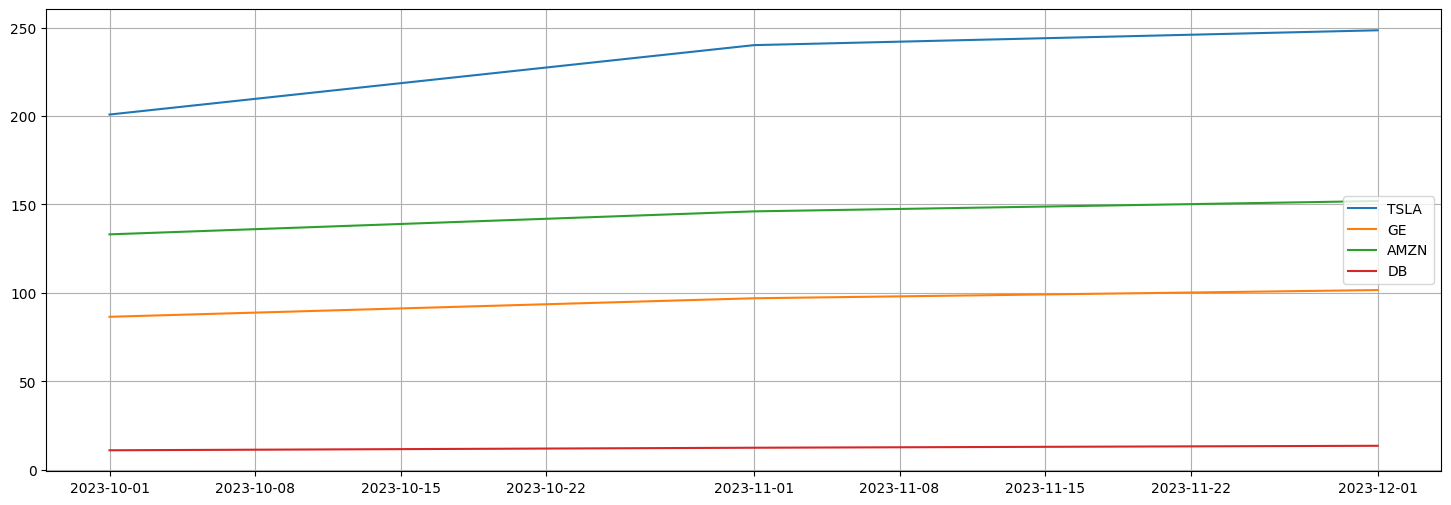

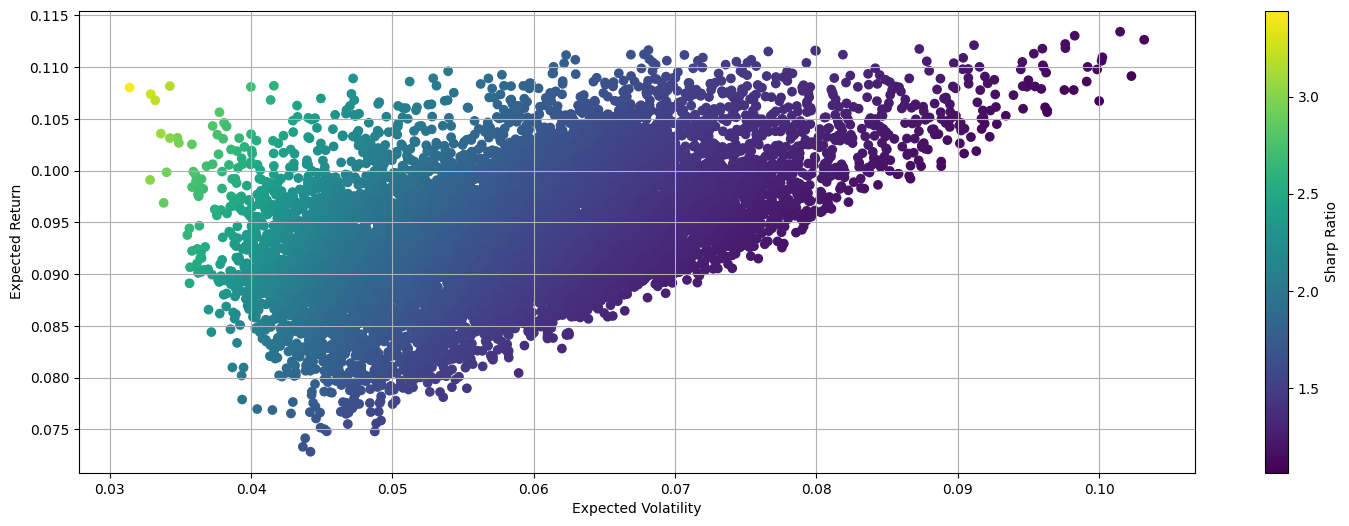

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.06886106 0.04075369 1.68968913]


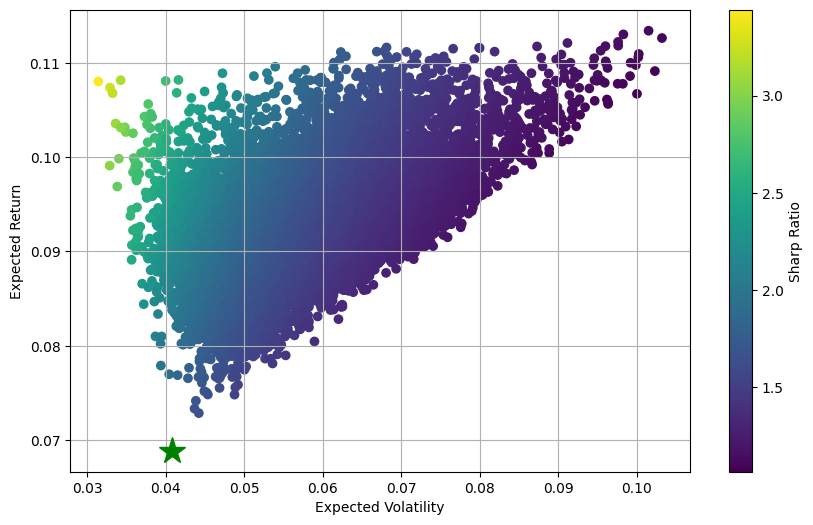

-----------------------------------------------------
------------------- Final results -------------------
Selected stock: ['TSLA', 'GE', 'AMZN', 'DB']
Weights: [0. 0. 1. 0.]
Returns: [0.         0.         0.09767827 0.        ]
-----------------------------------------------------


In [24]:
# print(stocks)
_, _, not_rebalance_returns = portfolio(stocks, df, 4, 2)
not_rebalance_returns = np.array(not_rebalance_returns[1:])

[*********************100%%**********************]  6 of 6 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.   0.   0.05 0.   0.   0.95]
Expected return, volatility and sharp ratio: [0.01487234 0.00814134 1.8267682 ]
From 2014-02-01 to 2014-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.   0.   0.05 0.   0.   0.95]
	 TSLA   NaN
GE     NaN
AMZN   NaN
DB     NaN
Name: 2014-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.006 0.877 0.099 0.018]
Expected return, volatility and sharp ratio: [1.49866850e-02 3.29639074e-05 4.54639214e+02]
From 2014-03-01 to 2014-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.006 0.877 0.099 0.018]
	 AAPL    0.051218
WMT     0.000268
AMZN    0.009507
DB      0.003321
Name: 2014-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.821 0.179 0.   ]
Expected return, volatility and sharp ratio: [0.01494766 0.01223735 1.22147812]
From 2014-04-01 to 2014-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.821 0.179 0.   ]
	 WMT     0.023159
GE      0.027642
AMZN   -0.071058
DB     -0.072611
Name: 2014-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.952 0.048 0.   ]
Expected return, volatility and sharp ratio: [0.01497934 0.0243113  0.61614704]
From 2014-05-01 to 2014-06-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.952 0.048 0.   ]
	 WMT     0.049643
GE      0.038625
AMZN   -0.095847
DB     -0.017845
Name: 2014-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.411 0.589 0.   ]
Expected return, volatility and sharp ratio: [1.50007640e-02 3.14454432e-04 4.77040947e+01]
From 2014-06-01 to 2014-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.411 0.589 0.   ]
	 TSLA   -0.000577
GE     -0.003719
AMZN    0.027685
DB     -0.079491
Name: 2014-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.328 0.    0.672 0.   ]
Expected return, volatility and sharp ratio: [0.01498811 0.08808051 0.17016379]
From 2014-07-01 to 2014-08-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.328 0.    0.672 0.   ]
	 AAPL    0.033401
TSLA    0.155412
AMZN    0.039130
DB     -0.067352
Name: 2014-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.435 0.    0.    0.565]
Expected return, volatility and sharp ratio: [0.01499697 0.02670065 0.56167065]
From 2014-08-01 to 2014-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.435 0.    0.    0.565]
	 AAPL    0.028732
TSLA   -0.069816
AMZN   -0.036302
DB     -0.028994
Name: 2014-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.242 0.    0.    0.758]
Expected return, volatility and sharp ratio: [0.01499871 0.00819717 1.82974298]
From 2014-09-01 to 2014-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.242 0.    0.    0.758]
	 AAPL    0.072176
GE      0.033002
AMZN    0.083229
DB      0.004391
Name: 2014-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.795 0.    0.    0.205]
Expected return, volatility and sharp ratio: [0.01499538 0.03025821 0.49558054]
From 2014-10-01 to 2014-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.795 0.    0.    0.205]
	 TSLA   -0.100185
GE     -0.013857
AMZN   -0.048962
DB      0.016030
Name: 2014-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.392 0.608 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01500687 0.0078988  1.89989171]
From 2014-11-01 to 2014-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.392 0.608 0.    0.   ]
	 WMT    -0.002615
GE      0.018099
AMZN   -0.052661
DB     -0.101549
Name: 2014-10-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.335 0.665 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502118 0.07353961 0.20425971]
From 2014-12-01 to 2015-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.335 0.665 0.    0.   ]
	 AAPL    0.101204
WMT     0.147764
AMZN    0.108623
DB      0.042465
Name: 2014-11-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.348 0.652 0.   ]
Expected return, volatility and sharp ratio: [0.0150127  0.10759316 0.13953206]
From 2015-01-01 to 2015-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.348 0.652 0.   ]
	 AAPL   -0.067866
GE     -0.046055
AMZN   -0.083540
DB     -0.080551
Name: 2014-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.022236   0.09286721 0.23943868]
From 2015-02-01 to 2015-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.084574
GE     -0.043432
AMZN    0.142355
DB     -0.034644
Name: 2015-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.609 0.    0.    0.391]
Expected return, volatility and sharp ratio: [0.01503655 0.04918768 0.30569748]
From 2015-03-01 to 2015-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.609 0.    0.    0.391]
	 TSLA   -0.001277
GE      0.087903
AMZN    0.072293
DB      0.129400
Name: 2015-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.168 0.208 0.048 0.576]
Expected return, volatility and sharp ratio: [1.49946752e-02 6.10870317e-06 2.45464132e+03]
From 2015-04-01 to 2015-05-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.168 0.208 0.048 0.576]
	 TSLA   -0.071653
GE     -0.034381
AMZN   -0.021202
DB      0.061106
Name: 2015-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.373 0.    0.    0.627]
Expected return, volatility and sharp ratio: [0.01505256 0.01574014 0.95631665]
From 2015-05-01 to 2015-06-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.373 0.    0.    0.627]
	 AAPL    0.005787
TSLA    0.197489
AMZN    0.133513
DB     -0.075727
Name: 2015-04-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.229 0.17  0.293 0.308]
Expected return, volatility and sharp ratio: [1.50185829e-02 3.14041579e-05 4.78235491e+02]
From 2015-06-01 to 2015-07-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.229 0.17  0.293 0.308]
	 AAPL    0.040991
WMT    -0.048431
AMZN    0.017663
DB     -0.058879
Name: 2015-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.618 0.    0.    0.382]
Expected return, volatility and sharp ratio: [0.01496172 0.03711652 0.40310135]
From 2015-07-01 to 2015-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.618 0.    0.    0.382]
	 TSLA    0.069617
GE     -0.025669
AMZN    0.011323
DB      0.024182
Name: 2015-06-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.652 0.348 0.   ]
Expected return, volatility and sharp ratio: [0.01502687 0.0878223  0.17110546]
From 2015-08-01 to 2015-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.652 0.348 0.   ]
	 TSLA   -0.007866
GE     -0.007197
AMZN    0.235113
DB      0.161141
Name: 2015-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [-0.0164631   0.04607375 -0.35732061]
From 2015-09-01 to 2015-10-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA   -0.064212
GE     -0.049042
AMZN   -0.043383
DB     -0.157624
Name: 2015-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.422 0.578 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499566 0.00961551 1.5595275 ]
From 2015-10-01 to 2015-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.422 0.578 0.    0.   ]
	 WMT     0.008539
GE      0.016116
AMZN   -0.001950
DB     -0.086102
Name: 2015-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.484 0.125 0.201 0.191]
Expected return, volatility and sharp ratio: [1.49932226e-02 1.02157341e-05 1.46765983e+03]
From 2015-11-01 to 2015-12-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.484 0.125 0.201 0.191]
	 WMT    -0.117212
TSLA   -0.166948
AMZN    0.222724
DB      0.036721
Name: 2015-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.549 0.184 0.004 0.263]
Expected return, volatility and sharp ratio: [1.50592831e-02 2.01446621e-05 7.47556999e+02]
From 2015-12-01 to 2016-01-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.549 0.184 0.004 0.263]
	 AAPL   -0.010042
WMT     0.027952
AMZN    0.062151
DB     -0.080859
Name: 2015-11-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.108 0.667 0.157 0.067]
Expected return, volatility and sharp ratio: [1.49799017e-02 2.21217739e-05 6.77156442e+02]
From 2016-01-01 to 2016-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.108 0.667 0.157 0.067]
	 WMT     0.041808
TSLA    0.042343
AMZN    0.016682
DB     -0.059946
Name: 2015-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.789 0.211 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01496983 0.02036753 0.73498487]
From 2016-02-01 to 2016-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.789 0.211 0.    0.   ]
	 AAPL   -0.075242
GE     -0.057039
AMZN   -0.131515
DB     -0.259213
Name: 2016-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.533 0.    0.467]
Expected return, volatility and sharp ratio: [0.01499191 0.0460073  0.32585934]
From 2016-03-01 to 2016-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.533 0.    0.467]
	 WMT    -0.000301
TSLA    0.003818
AMZN   -0.058739
DB     -0.039128
Name: 2016-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.842 0.    0.    0.158]
Expected return, volatility and sharp ratio: [0.01500062 0.01412765 1.06179159]
From 2016-04-01 to 2016-05-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.842 0.    0.    0.158]
	 AAPL    0.133327
TSLA    0.197155
AMZN    0.074423
DB     -0.014543
Name: 2016-03-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.305 0.324 0.264 0.108]
Expected return, volatility and sharp ratio: [1.50191366e-02 1.31540989e-05 1.14178377e+03]
From 2016-05-01 to 2016-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.305 0.324 0.264 0.108]
	 WMT    -0.016425
TSLA    0.047830
AMZN    0.111094
DB      0.119244
Name: 2016-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.692 0.308 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01502759 0.00425516 3.53161608]
From 2016-06-01 to 2016-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.308 0.    0.   ]
	 AAPL    0.065287
GE     -0.016910
AMZN    0.095817
DB     -0.061181
Name: 2016-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.676 0.28  0.044]
Expected return, volatility and sharp ratio: [1.50711827e-02 6.08299130e-05 2.47759400e+02]
From 2016-07-01 to 2016-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.676 0.28  0.044]
	 AAPL   -0.036831
WMT     0.039201
AMZN   -0.009920
DB     -0.228652
Name: 2016-06-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.069 0.49  0.227 0.215]
Expected return, volatility and sharp ratio: [1.50337425e-02 5.68227736e-06 2.64572487e+03]
From 2016-08-01 to 2016-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.069 0.49  0.227 0.215]
	 AAPL    0.090062
TSLA    0.106039
AMZN    0.060353
DB     -0.021122
Name: 2016-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.438 0.172 0.169 0.22 ]
Expected return, volatility and sharp ratio: [1.49819964e-02 3.15873004e-05 4.74304425e+02]
From 2016-09-01 to 2016-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.438 0.172 0.169 0.22 ]
	 AAPL    0.018137
GE      0.003212
AMZN    0.013640
DB      0.097470
Name: 2016-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.452 0.115 0.187 0.247]
Expected return, volatility and sharp ratio: [1.49977600e-02 3.74270749e-05 4.00719534e+02]
From 2016-10-01 to 2016-11-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.452 0.115 0.187 0.247]
	 AAPL    0.071276
TSLA   -0.037640
AMZN    0.088603
DB     -0.112542
Name: 2016-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.06  0.065 0.449 0.425]
Expected return, volatility and sharp ratio: [1.49954921e-02 1.09093879e-06 1.37454936e+04]
From 2016-11-01 to 2016-12-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.06  0.065 0.449 0.425]
	 AAPL    0.004334
GE     -0.007929
AMZN   -0.056717
DB      0.099312
Name: 2016-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.597 0.403 0.   ]
Expected return, volatility and sharp ratio: [1.49778545e-02 1.34216010e-03 1.11595140e+01]
From 2016-12-01 to 2017-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.597 0.403 0.   ]
	 WMT     0.005856
GE      0.057045
AMZN   -0.049695
DB      0.097985
Name: 2016-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.384 0.235 0.271 0.11 ]
Expected return, volatility and sharp ratio: [1.50129272e-02 3.11207873e-05 4.82408335e+02]
From 2017-01-01 to 2017-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.384 0.235 0.271 0.11 ]
	 WMT    -0.018600
GE      0.027308
AMZN   -0.000933
DB      0.145570
Name: 2016-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.166 0.42  0.204 0.21 ]
Expected return, volatility and sharp ratio: [1.49654253e-02 4.58591028e-05 3.26334891e+02]
From 2017-02-01 to 2017-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.166 0.42  0.204 0.21 ]
	 TSLA    0.178951
GE     -0.051247
AMZN    0.098164
DB      0.100000
Name: 2017-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.036 0.163 0.632 0.169]
Expected return, volatility and sharp ratio: [1.49910869e-02 2.07821043e-05 7.21345957e+02]
From 2017-03-01 to 2017-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.036 0.163 0.632 0.169]
	 WMT     0.062781
TSLA   -0.007701
AMZN    0.026182
DB     -0.011050
Name: 2017-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.628 0.372]
Expected return, volatility and sharp ratio: [0.01500322 0.04519963 0.33193247]
From 2017-04-01 to 2017-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.628 0.372]
	 WMT     0.016213
TSLA    0.113245
AMZN    0.049110
DB     -0.128492
Name: 2017-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.098 0.902]
Expected return, volatility and sharp ratio: [0.01500478 0.05243742 0.28614649]
From 2017-05-01 to 2017-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.098 0.902]
	 TSLA    0.128530
GE     -0.027181
AMZN    0.043371
DB      0.053030
Name: 2017-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.292 0.304 0.185 0.218]
Expected return, volatility and sharp ratio: [1.49764485e-02 6.10925941e-06 2.45143437e+03]
From 2017-06-01 to 2017-07-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.292 0.304 0.185 0.218]
	 AAPL    0.063418
TSLA    0.085777
AMZN    0.075276
DB     -0.032651
Name: 2017-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.041 0.    0.    0.959]
Expected return, volatility and sharp ratio: [0.01500401 0.01551092 0.96731892]
From 2017-07-01 to 2017-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.041 0.    0.    0.959]
	 TSLA    0.060409
GE     -0.013513
AMZN   -0.026764
DB      0.029362
Name: 2017-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0065825  0.01958877 0.33603449]
From 2017-08-01 to 2017-09-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.105473
GE     -0.041789
AMZN    0.020434
DB      0.002811
Name: 2017-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.649 0.    0.    0.351]
Expected return, volatility and sharp ratio: [0.01499829 0.01933187 0.77583261]
From 2017-09-01 to 2017-10-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.649 0.    0.    0.351]
	 AAPL    0.102670
TSLA    0.100257
AMZN   -0.007269
DB     -0.103700
Name: 2017-08-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.211 0.159 0.172 0.458]
Expected return, volatility and sharp ratio: [1.49875818e-02 5.73146611e-05 2.61496475e+02]
From 2017-10-01 to 2017-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.211 0.159 0.172 0.458]
	 TSLA   -0.041585
GE     -0.015071
AMZN   -0.019631
DB      0.080675
Name: 2017-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.447 0.052 0.312 0.19 ]
Expected return, volatility and sharp ratio: [1.49909313e-02 3.79929195e-05 3.94571711e+02]
From 2017-11-01 to 2017-12-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.447 0.052 0.312 0.19 ]
	 WMT     0.117353
TSLA   -0.028056
AMZN    0.149717
DB     -0.058449
Name: 2017-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.476 0.524 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01495916 0.00463335 3.22858506]
From 2017-12-01 to 2018-01-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.476 0.524 0.    0.   ]
	 AAPL    0.016623
GE     -0.092758
AMZN    0.064662
DB      0.159189
Name: 2017-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.219 0.781]
Expected return, volatility and sharp ratio: [0.01503347 0.01322089 1.1370996 ]
From 2018-01-01 to 2018-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.219 0.781]
	 WMT     0.015633
GE     -0.045926
AMZN   -0.006187
DB      0.009014
Name: 2017-12-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.532 0.468 0.   ]
Expected return, volatility and sharp ratio: [0.01497493 0.0889441  0.16836344]
From 2018-02-01 to 2018-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.532 0.468 0.   ]
	 TSLA    0.137980
GE     -0.065322
AMZN    0.240639
DB     -0.036259
Name: 2018-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00031015  0.06044238 -0.00513138]
From 2018-03-01 to 2018-04-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.031752
GE     -0.127396
AMZN    0.042429
DB     -0.130862
Name: 2018-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.301 0.699 0.   ]
Expected return, volatility and sharp ratio: [0.01500098 0.07855059 0.19097228]
From 2018-04-01 to 2018-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.301 0.699 0.   ]
	 AAPL   -0.054211
GE     -0.034722
AMZN   -0.043049
DB     -0.122961
Name: 2018-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.385 0.105 0.265 0.245]
Expected return, volatility and sharp ratio: [1.49213848e-02 4.76499863e-05 3.13145627e+02]
From 2018-05-01 to 2018-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.385 0.105 0.265 0.245]
	 WMT     0.000196
TSLA    0.104347
AMZN    0.082075
DB     -0.022890
Name: 2018-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.824 0.176]
Expected return, volatility and sharp ratio: [0.01506855 0.02107979 0.71483387]
From 2018-06-01 to 2018-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.824 0.176]
	 WMT    -0.066923
TSLA   -0.031201
AMZN    0.040539
DB     -0.188873
Name: 2018-05-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.03690696 0.2369761  0.15574126]
From 2018-07-01 to 2018-08-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.044216
GE     -0.033381
AMZN    0.043065
DB     -0.031315
Name: 2018-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.685 0.315 0.   ]
Expected return, volatility and sharp ratio: [0.01502931 0.01133023 1.32647911]
From 2018-08-01 to 2018-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.685 0.315 0.   ]
	 WMT     0.041798
TSLA   -0.130660
AMZN    0.045676
DB      0.229755
Name: 2018-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.   0.   0.62 0.38]
Expected return, volatility and sharp ratio: [0.015038   0.02072431 0.72562124]
From 2018-09-01 to 2018-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.   0.62 0.38]
	 WMT     0.074303
TSLA    0.011807
AMZN    0.132364
DB     -0.137825
Name: 2018-08-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.874 0.    0.    0.126]
Expected return, volatility and sharp ratio: [0.01498086 0.03771396 0.39722334]
From 2018-10-01 to 2018-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.874 0.    0.    0.126]
	 TSLA   -0.122290
GE     -0.127512
AMZN   -0.004824
DB      0.008881
Name: 2018-09-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
/var/folders/s_/20wwypx94lvg6dgc7vypd2l80000gn/T/ipykernel_16242/1562545401.py:88: RuntimeWarning: invalid value encountered in sqrt
  portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
[*********************100%%**********************]  4 of 4 completed


Optimal portfolio: [0.429 0.09  0.428 0.053]
Expected return, volatility and sharp ratio: [1.50075689e-02 9.15881533e-05 1.63859280e+02]
From 2018-11-01 to 2018-12-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.429 0.09  0.428 0.053]
	 AAPL   -0.030478
GE     -0.094693
AMZN   -0.202192
DB     -0.139965
Name: 2018-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.02683897  0.11951622 -0.22456345]
From 2018-12-01 to 2019-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.039013
GE     -0.257426
AMZN    0.057672
DB     -0.062436
Name: 2018-11-01 00:00:00, dtype: float64



[                       0%%                      ]

Optimal portfolio: [0.672 0.328 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01504372 0.06488603 0.23184835]
From 2019-01-01 to 2019-02-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.672 0.328 0.    0.   ]
	 WMT    -0.046083
GE      0.009333
AMZN   -0.111350
DB     -0.110262
Name: 2018-12-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [3.36799013e-02 9.96892736e-04 3.37848798e+01]
From 2019-02-01 to 2019-03-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.055154
GE      0.344454
AMZN    0.144317
DB      0.089571
Name: 2019-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.239 0.159 0.337 0.265]
Expected return, volatility and sharp ratio: [1.50215217e-02 1.40215062e-05 1.07132012e+03]
From 2019-03-01 to 2019-04-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.239 0.159 0.337 0.265]
	 WMT     0.032975
GE      0.063543
AMZN   -0.045906
DB      0.040541
Name: 2019-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.737 0.263 0.   ]
Expected return, volatility and sharp ratio: [0.01501596 0.02939914 0.51076199]
From 2019-04-01 to 2019-05-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.737 0.263 0.   ]
	 TSLA   -0.125109
GE     -0.038498
AMZN    0.085936
DB     -0.121212
Name: 2019-03-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.00162277 0.1134708  0.01430125]
From 2019-05-01 to 2019-06-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA   -0.147109
GE      0.019369
AMZN    0.081859
DB      0.019704
Name: 2019-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.799 0.201 0.   ]
Expected return, volatility and sharp ratio: [0.01499494 0.12466054 0.12028615]
From 2019-06-01 to 2019-07-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.799 0.201 0.   ]
	 AAPL   -0.127573
GE     -0.071780
AMZN   -0.078613
DB     -0.182367
Name: 2019-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.02630628 0.05725509 0.45945749]
From 2019-07-01 to 2019-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.206848
GE      0.112288
AMZN    0.066792
DB      0.146536
Name: 2019-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.00750008 0.10425929 0.07193682]
From 2019-08-01 to 2019-09-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076395
GE     -0.003561
AMZN   -0.014179
DB      0.023591
Name: 2019-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.79 0.   0.21 0.  ]
Expected return, volatility and sharp ratio: [0.01498072 0.05813224 0.25770075]
From 2019-09-01 to 2019-10-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.79 0.   0.21 0.  ]
	 WMT     0.035151
GE     -0.210526
AMZN   -0.048474
DB     -0.071703
Name: 2019-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.271 0.103 0.474 0.152]
Expected return, volatility and sharp ratio: [1.49526084e-02 4.41058148e-06 3.39016715e+03]
From 2019-10-01 to 2019-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.271 0.103 0.474 0.152]
	 AAPL    0.077038
WMT     0.043797
AMZN   -0.022733
DB      0.034483
Name: 2019-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.11  0.058 0.55  0.281]
Expected return, volatility and sharp ratio: [1.50148745e-02 1.53735038e-05 9.76672246e+02]
From 2019-11-01 to 2019-12-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.11  0.058 0.55  0.281]
	 AAPL    0.110685
TSLA    0.307427
AMZN    0.023475
DB     -0.033333
Name: 2019-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.0198545  0.00886315 2.24011645]
From 2019-12-01 to 2020-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.047695
GE      0.129258
AMZN    0.013587
DB     -0.005517
Name: 2019-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.0535492  0.08953371 0.59808981]
From 2020-01-01 to 2020-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 TSLA    0.267897
GE     -0.009760
AMZN    0.026122
DB      0.079057
Name: 2019-12-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.009 0.    0.991 0.   ]
Expected return, volatility and sharp ratio: [0.01493193 0.10796776 0.13829989]
From 2020-02-01 to 2020-03-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.009 0.    0.991 0.   ]
	 AAPL    0.054009
TSLA    0.555160
AMZN    0.087064
DB      0.176092
Name: 2020-01-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.01359657  0.06875503 -0.1977539 ]
From 2020-03-01 to 2020-04-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 WMT    -0.059481
GE     -0.126105
AMZN   -0.062214
DB     -0.046995
Name: 2020-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.816 0.184 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01494272 0.0277892  0.53771692]
From 2020-04-01 to 2020-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.816 0.184 0.    0.   ]
	 AAPL   -0.067554
GE     -0.270220
AMZN    0.035021
DB     -0.263762
Name: 2020-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.373 0.508 0.098 0.021]
Expected return, volatility and sharp ratio: [1.50835829e-02 9.28746046e-05 1.62408045e+02]
From 2020-05-01 to 2020-06-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.373 0.508 0.098 0.021]
	 AAPL    0.155374
TSLA    0.492137
AMZN    0.268900
DB      0.154206
Name: 2020-04-01 00:00:00, dtype: float64



[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.05839089 0.10065783 0.58009291]
From 2020-06-01 to 2020-07-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 WMT     0.020650
GE     -0.033824
AMZN   -0.012785
DB      0.133603
Name: 2020-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************75%%**********            ]  3 of 4 completed

Optimal portfolio: [0.566 0.272 0.045 0.116]
Expected return, volatility and sharp ratio: [1.49465282e-02 1.13338485e-05 1.31875137e+03]
From 2020-07-01 to 2020-08-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.566 0.272 0.045 0.116]
	 WMT    -0.030252
GE      0.039574
AMZN    0.129567
DB      0.133333
Name: 2020-06-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.435 0.565 0.    0.   ]
Expected return, volatility and sharp ratio: [0.014955   0.05931843 0.25211386]
From 2020-08-01 to 2020-09-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.435 0.565 0.    0.   ]
	 AAPL    0.165132
GE     -0.109604
AMZN    0.147114
DB     -0.063025
Name: 2020-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.033 0.967 0.    0.   ]
Expected return, volatility and sharp ratio: [0.01499014 0.04963555 0.30200404]
From 2020-09-01 to 2020-10-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.033 0.967 0.    0.   ]
	 AAPL    0.214380
WMT     0.073029
AMZN    0.090461
DB      0.068386
Name: 2020-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.00174291 0.01418989 0.12282743]
From 2020-10-01 to 2020-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.011777
GE     -0.017350
AMZN   -0.087579
DB     -0.118573
Name: 2020-09-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.925 0.075]
Expected return, volatility and sharp ratio: [0.0149304  0.05715351 0.26123333]
From 2020-11-01 to 2020-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.925 0.075]
	 WMT    -0.008291
GE      0.193479
AMZN   -0.035754
DB      0.101191
Name: 2020-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02232044 0.11153705 0.20011685]
From 2020-12-01 to 2021-01-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.093607
GE      0.371968
AMZN    0.043440
DB      0.202162
Name: 2020-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.456 0.544 0.   ]
Expected return, volatility and sharp ratio: [0.01500787 0.03963758 0.37862731]
From 2021-01-01 to 2021-02-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.456 0.544 0.   ]
	 WMT    -0.056548
TSLA    0.243252
AMZN    0.028058
DB     -0.019784
Name: 2020-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.066 0.375 0.174 0.385]
Expected return, volatility and sharp ratio: [1.49457281e-02 6.03566220e-05 2.47623667e+02]
From 2021-02-01 to 2021-03-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.066 0.375 0.174 0.385]
	 AAPL   -0.005501
WMT    -0.021828
AMZN   -0.015576
DB     -0.071560
Name: 2021-01-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.062 0.455 0.195 0.288]
Expected return, volatility and sharp ratio: [1.50090082e-02 3.93050025e-05 3.81859999e+02]
From 2021-03-01 to 2021-04-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.062 0.455 0.195 0.288]
	 AAPL   -0.081085
GE      0.174157
AMZN   -0.035328
DB      0.212451
Name: 2021-02-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.02360565 0.0331545  0.7119893 ]
From 2021-04-01 to 2021-05-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT     0.045489
GE      0.047049
AMZN    0.000372
DB     -0.022005
Name: 2021-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.02474542 0.01356643 1.82401856]
From 2021-05-01 to 2021-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.076218
GE      0.000162
AMZN    0.120663
DB      0.166667
Name: 2021-04-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.296 0.559 0.141 0.004]
Expected return, volatility and sharp ratio: [1.49999378e-02 2.38143917e-06 6.29868612e+03]
From 2021-06-01 to 2021-07-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.296 0.559 0.141 0.004]
	 WMT     0.015153
GE      0.071647
AMZN   -0.070470
DB      0.077857
Name: 2021-05-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.172 0.    0.828 0.   ]
Expected return, volatility and sharp ratio: [0.01499477 0.05688351 0.26360492]
From 2021-07-01 to 2021-08-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.172 0.    0.828 0.   ]
	 TSLA    0.087137
GE     -0.042674
AMZN    0.067355
DB     -0.133201
Name: 2021-06-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.626 0.    0.    0.374]
Expected return, volatility and sharp ratio: [0.01501246 0.03451124 0.43500194]
From 2021-08-01 to 2021-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.626 0.    0.    0.374]
	 AAPL    0.064982
TSLA    0.011034
AMZN   -0.032722
DB     -0.043578
Name: 2021-07-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.089 0.195 0.121 0.595]
Expected return, volatility and sharp ratio: [1.50009403e-02 9.98616553e-06 1.50217221e+03]
From 2021-09-01 to 2021-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.089 0.195 0.121 0.595]
	 WMT     0.038934
TSLA    0.070605
AMZN    0.043034
DB     -0.012790
Name: 2021-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.011 0.005 0.153 0.83 ]
Expected return, volatility and sharp ratio: [1.49411392e-02 7.55583015e-05 1.97743185e+02]
From 2021-10-01 to 2021-11-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.011 0.005 0.153 0.83 ]
	 WMT    -0.055416
GE     -0.022579
AMZN   -0.053518
DB      0.028340
Name: 2021-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.694 0.306]
Expected return, volatility and sharp ratio: [0.01498268 0.00900963 1.66296346]
From 2021-11-01 to 2021-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.694 0.306]
	 TSLA    0.436530
GE      0.018851
AMZN    0.026602
DB      0.009449
Name: 2021-10-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [-0.00466413  0.06305672 -0.07396727]
From 2021-12-01 to 2022-01-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 1. 0.]
	 TSLA    0.027612
GE     -0.094212
AMZN    0.039924
DB     -0.062402
Name: 2021-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.264 0.264 0.472]
Expected return, volatility and sharp ratio: [0.0150289  0.01503038 0.99990165]
From 2022-01-01 to 2022-02-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.    0.264 0.264 0.472]
	 AAPL    0.075796
GE     -0.005474
AMZN   -0.049252
DB      0.039933
Name: 2021-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 1. 0. 0.]
Expected return, volatility and sharp ratio: [0.00605263 0.00685793 0.88257301]
From 2022-02-01 to 2022-03-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0. 1. 0. 0.]
	 WMT    -0.029837
GE      0.001203
AMZN   -0.102830
DB      0.111200
Name: 2022-01-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.069 0.476 0.454 0.   ]
Expected return, volatility and sharp ratio: [1.49679112e-02 5.05294002e-05 2.96221826e+02]
From 2022-03-01 to 2022-04-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.069 0.476 0.454 0.   ]
	 WMT    -0.033259
TSLA   -0.070768
AMZN    0.026673
DB     -0.105112
Name: 2022-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.692 0.    0.    0.308]
Expected return, volatility and sharp ratio: [0.01505951 0.08604211 0.17502486]
From 2022-04-01 to 2022-05-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.692 0.    0.    0.308]
	 AAPL    0.058821
GE     -0.041985
AMZN    0.061437
DB      0.017699
Name: 2022-03-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.04369665  0.24787715 -0.17628348]
From 2022-05-01 to 2022-06-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.031303
TSLA   -0.191945
AMZN   -0.237525
DB     -0.218972
Name: 2022-04-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.03495355  0.23551254 -0.1484148 ]
From 2022-06-01 to 2022-07-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.129197
GE      0.050168
AMZN   -0.032764
DB      0.131579
Name: 2022-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.654 0.346]
Expected return, volatility and sharp ratio: [0.01495183 0.22744843 0.06573721]
From 2022-07-01 to 2022-08-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.654 0.346]
	 AAPL   -0.080080
WMT    -0.051373
AMZN   -0.116459
DB     -0.201486
Name: 2022-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.   0.57 0.   0.43]
Expected return, volatility and sharp ratio: [0.01501057 0.0461029  0.32558828]
From 2022-08-01 to 2022-09-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.   0.57 0.   0.43]
	 WMT     0.086116
TSLA    0.323765
AMZN    0.270596
DB     -0.003432
Name: 2022-07-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [-0.00672664  0.01486776 -0.45243104]
From 2022-09-01 to 2022-10-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL   -0.032552
GE     -0.006359
AMZN   -0.060615
DB     -0.045924
Name: 2022-08-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.401 0.599]
Expected return, volatility and sharp ratio: [0.01491812 0.17546148 0.08502221]
From 2022-10-01 to 2022-11-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.    0.    0.401 0.599]
	 AAPL   -0.119756
WMT    -0.017240
AMZN   -0.108622
DB     -0.109507
Name: 2022-09-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.559 0.436 0.005]
Expected return, volatility and sharp ratio: [1.51139484e-02 6.90136674e-05 2.18999351e+02]
From 2022-11-01 to 2022-12-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.559 0.436 0.005]
	 WMT     0.097379
GE      0.258779
AMZN   -0.093451
DB      0.294594
Name: 2022-10-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.    0.429 0.571]
Expected return, volatility and sharp ratio: [0.01497896 0.03238047 0.46259231]
From 2022-12-01 to 2023-01-01 was selected ['WMT', 'GE', 'AMZN', 'DB']

	 [0.    0.    0.429 0.571]
	 WMT     0.070892
GE      0.104871
AMZN   -0.057595
DB      0.109603
Name: 2022-11-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.726 0.    0.    0.274]
Expected return, volatility and sharp ratio: [0.01498759 0.06035747 0.2483137 ]
From 2023-01-01 to 2023-02-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.726 0.    0.    0.274]
	 TSLA   -0.367334
GE     -0.025358
AMZN   -0.129894
DB      0.083725
Name: 2022-12-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.04634946 0.16278842 0.28472211]
From 2023-02-01 to 2023-03-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA    0.406235
GE      0.231886
AMZN    0.227738
DB      0.161458
Name: 2023-01-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.156 0.386 0.169 0.289]
Expected return, volatility and sharp ratio: [1.50519855e-02 5.68633326e-05 2.64704597e+02]
From 2023-03-01 to 2023-04-01 was selected ['AAPL', 'WMT', 'AMZN', 'DB']

	 [0.156 0.386 0.169 0.289]
	 AAPL    0.021623
WMT    -0.012094
AMZN   -0.086299
DB     -0.068759
Name: 2023-02-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.    0.788 0.    0.212]
Expected return, volatility and sharp ratio: [0.01497115 0.03359932 0.44557903]
From 2023-04-01 to 2023-05-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.788 0.    0.212]
	 WMT     0.037431
TSLA    0.008507
AMZN    0.096148
DB     -0.180578
Name: 2023-03-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.153 0.163 0.154 0.529]
Expected return, volatility and sharp ratio: [1.50126417e-02 6.96182613e-05 2.15642296e+02]
From 2023-05-01 to 2023-06-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [0.153 0.163 0.154 0.529]
	 AAPL    0.028987
GE      0.036454
AMZN    0.020912
DB      0.078355
Name: 2023-04-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0.    0.    0.162 0.838]
Expected return, volatility and sharp ratio: [0.01502337 0.08309728 0.18079257]
From 2023-06-01 to 2023-07-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0.    0.    0.162 0.838]
	 WMT    -0.027158
TSLA    0.241130
AMZN    0.143480
DB     -0.079927
Name: 2023-05-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [1. 0. 0. 0.]
Expected return, volatility and sharp ratio: [0.04565698 0.04045574 1.12856622]
From 2023-07-01 to 2023-08-01 was selected ['AAPL', 'GE', 'AMZN', 'DB']

	 [1. 0. 0. 0.]
	 AAPL    0.095844
GE      0.081946
AMZN    0.081108
DB      0.072366
Name: 2023-06-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.314 0.    0.686 0.   ]
Expected return, volatility and sharp ratio: [0.01499582 0.00917792 1.63390207]
From 2023-08-01 to 2023-09-01 was selected ['AAPL', 'TSLA', 'AMZN', 'DB']

	 [0.314 0.    0.686 0.   ]
	 AAPL    0.012786
TSLA    0.021622
AMZN    0.025468
DB      0.056980
Name: 2023-07-01 00:00:00, dtype: float64



[**********************50%%                      ]  2 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [-0.00619032  0.02174071 -0.284734  ]
From 2023-09-01 to 2023-10-01 was selected ['WMT', 'TSLA', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 WMT     0.017203
TSLA   -0.034962
AMZN    0.032391
DB     -0.021563
Name: 2023-08-01 00:00:00, dtype: float64


[*********************100%%**********************]  4 of 4 completed
[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0. 0. 0. 1.]
Expected return, volatility and sharp ratio: [0.00550128 0.00520629 1.05666049]
From 2023-10-01 to 2023-11-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0. 0. 0. 1.]
	 TSLA   -0.030456
GE     -0.034160
AMZN   -0.078907
DB      0.009183
Name: 2023-09-01 00:00:00, dtype: float64



[*********************100%%**********************]  4 of 4 completed

Optimal portfolio: [0.7 0.3 0.  0. ]
Expected return, volatility and sharp ratio: [0.01502493 0.2236039  0.06719441]
From 2023-11-01 to 2023-12-01 was selected ['TSLA', 'GE', 'AMZN', 'DB']

	 [0.7 0.3 0.  0. ]
	 TSLA   -0.197346
GE     -0.016482
AMZN    0.046963
DB      0.001820
Name: 2023-10-01 00:00:00, dtype: float64


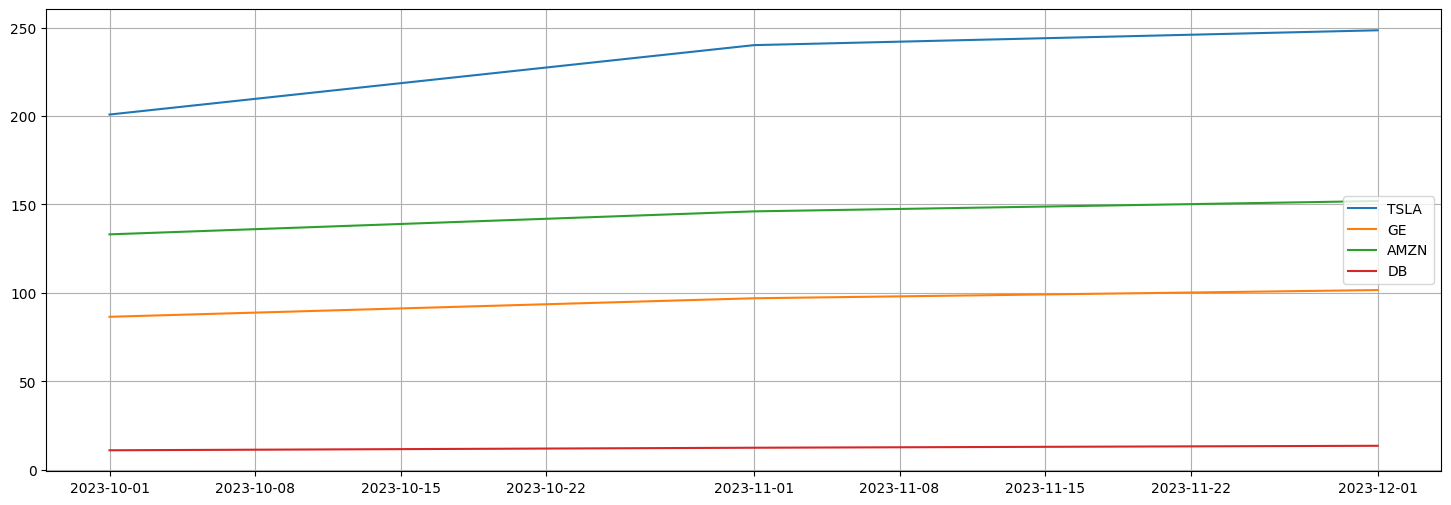

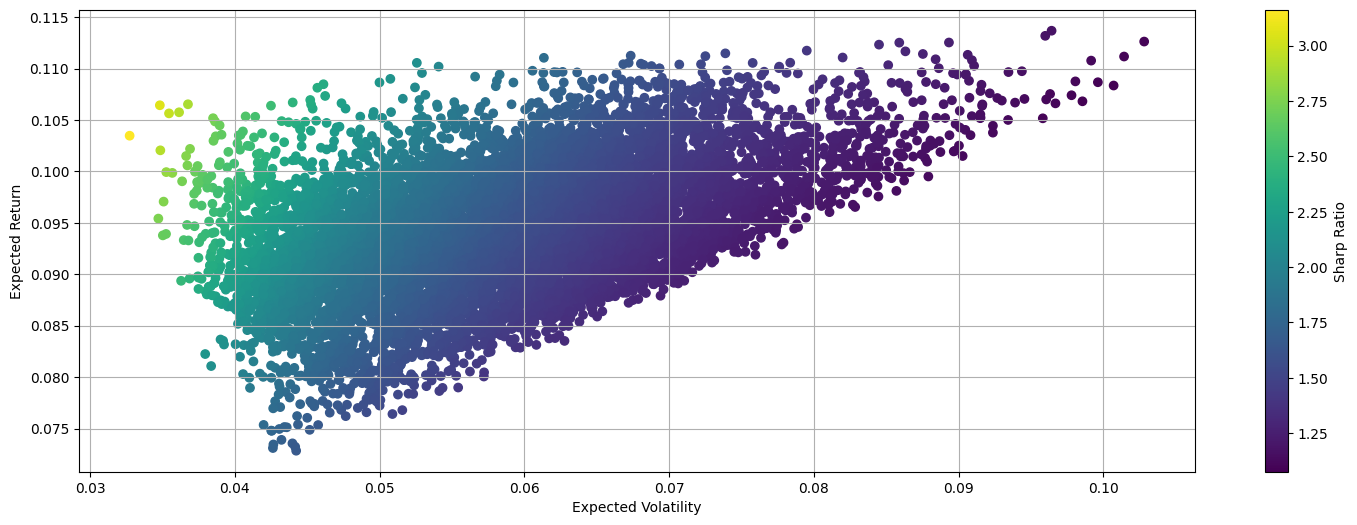

Optimal portfolio: [0. 0. 1. 0.]
Expected return, volatility and sharp ratio: [0.06886106 0.04075369 1.68968913]


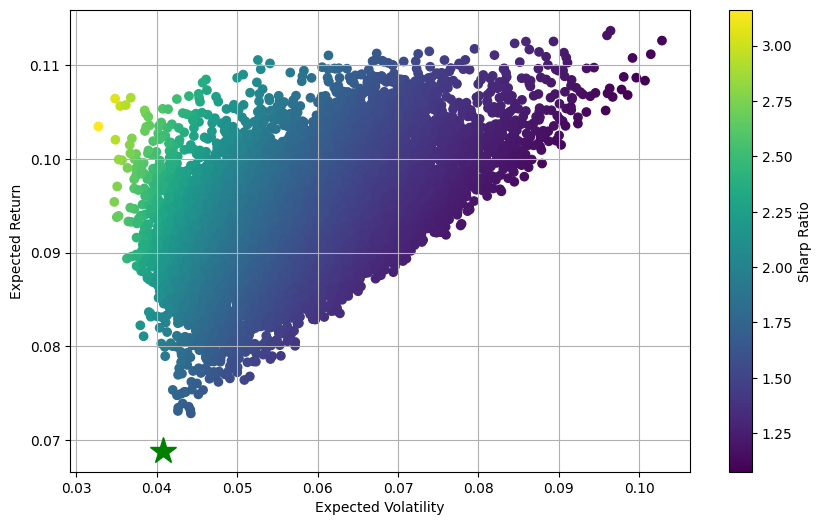

-----------------------------------------------------
------------------- Final results -------------------
Selected stock: ['TSLA', 'GE', 'AMZN', 'DB']
Weights: [0. 0. 1. 0.]
Returns: [0.         0.         0.09767827 0.        ]
-----------------------------------------------------


In [25]:
# print(returns)
_, _, returns = portfolio(stocks, df, 4, 2)
returns = np.array(returns[1:])
# print(returns)

In [26]:
# генерируем массив дат с шагом в месяц
start_month = 1
start_year = 2014
end_month = 1
end_year = 2024
curr_month = start_month
curr_year = start_year

start_datetime = datetime.datetime(start_year, start_month, 1)
curr_datetime = datetime.datetime(start_year, start_month, 1)
end_datetime = datetime.datetime(end_year, end_month, 1)

dates = []
while curr_datetime < end_datetime:
    dates.append(curr_datetime.strftime("%Y-%m-%d")) 
    curr_datetime += relativedelta(months=1)
dates.append(end_datetime.strftime("%Y-%m-%d"))
print(dates)

['2014-01-01', '2014-02-01', '2014-03-01', '2014-04-01', '2014-05-01', '2014-06-01', '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01', '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019

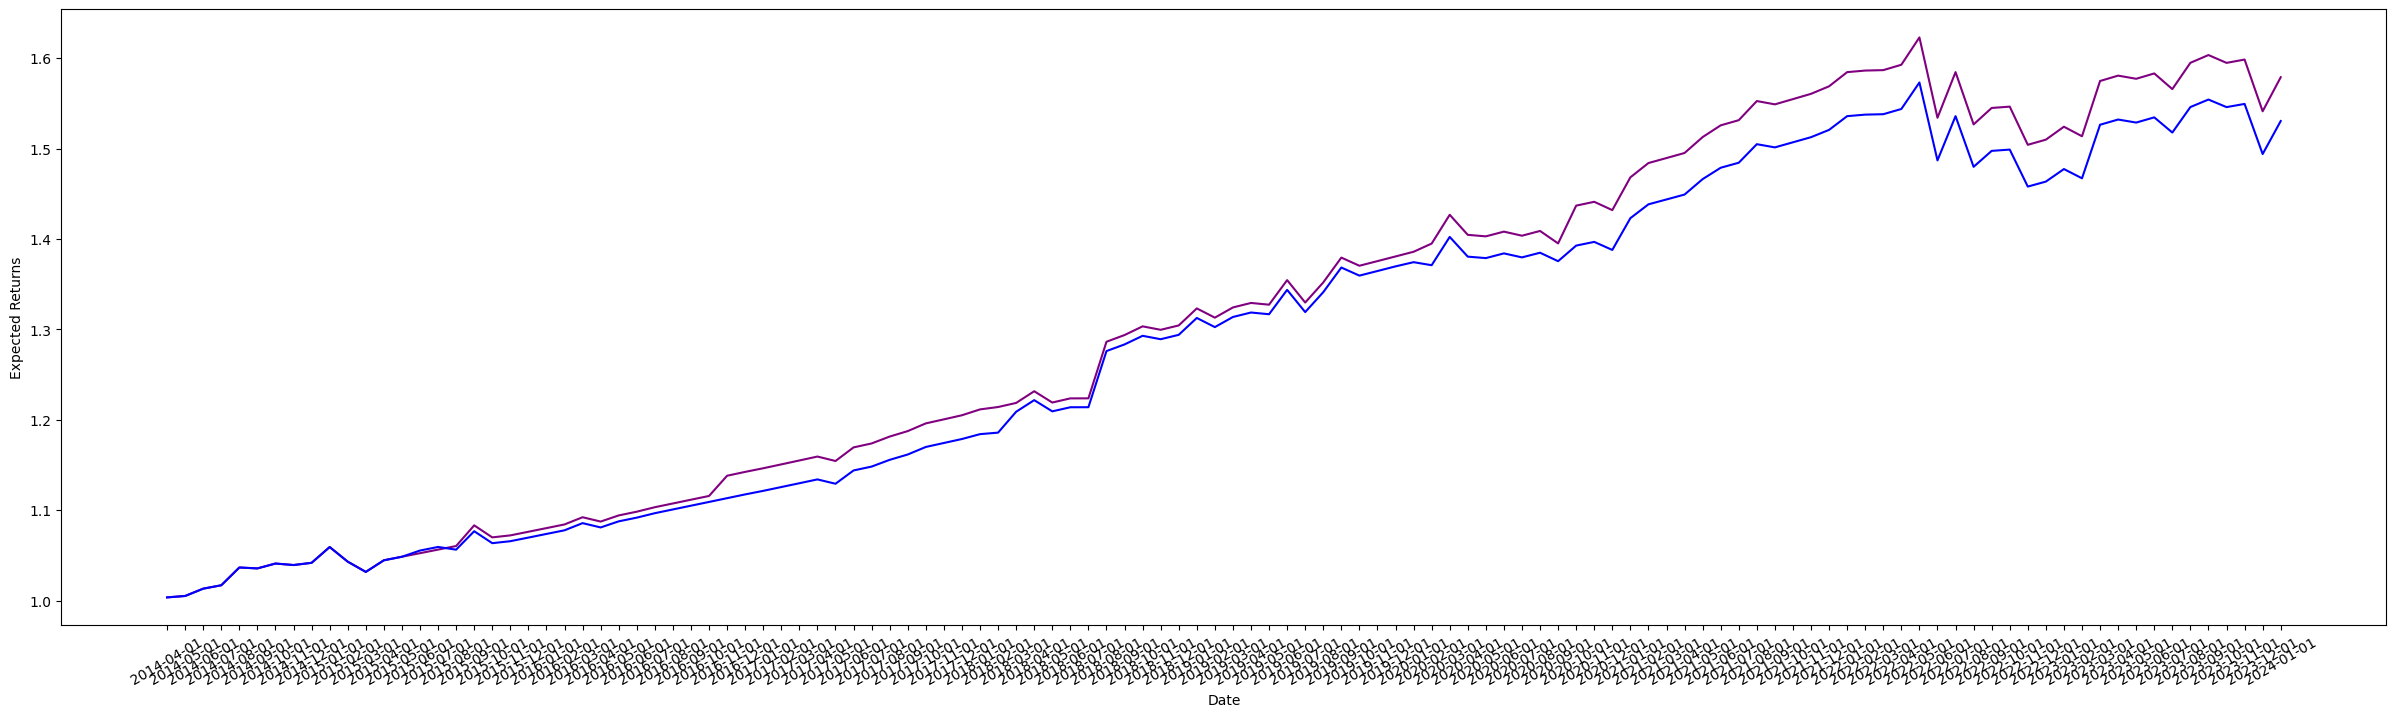

In [27]:
# Рисуем график для нашей стратегии с ребалансировкой
# print(len(returns))
# print(len(dates))

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Expected Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[3:],
    (1 + not_rebalance_returns).cumprod(), color:='purple'
    # markersize = 20
)
plt.plot(
    dates[3:],
    (1 + returns).cumprod(), color:='blue'
    # markersize = 20
)
plt.show()

In [28]:
# Рисуем график для общепринятого индекса S&P500

sp500 = yf.download("^GSPC", start = start_datetime, end = end_datetime, interval='1mo')
# print(sp500)
close = sp500["Close"]
sp500["monthly_returns"] = sp500["Adj Close"].pct_change().fillna(0)
# print(len(sp500["monthly_returns"]))
# plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod())
# plt.title("S&P500 Index Return vs Rebalancing Strategy Return")
# plt.ylabel("cumulative return")
# plt.xlabel("months")
# plt.legend("Index Return")

[*********************100%%**********************]  1 of 1 completed


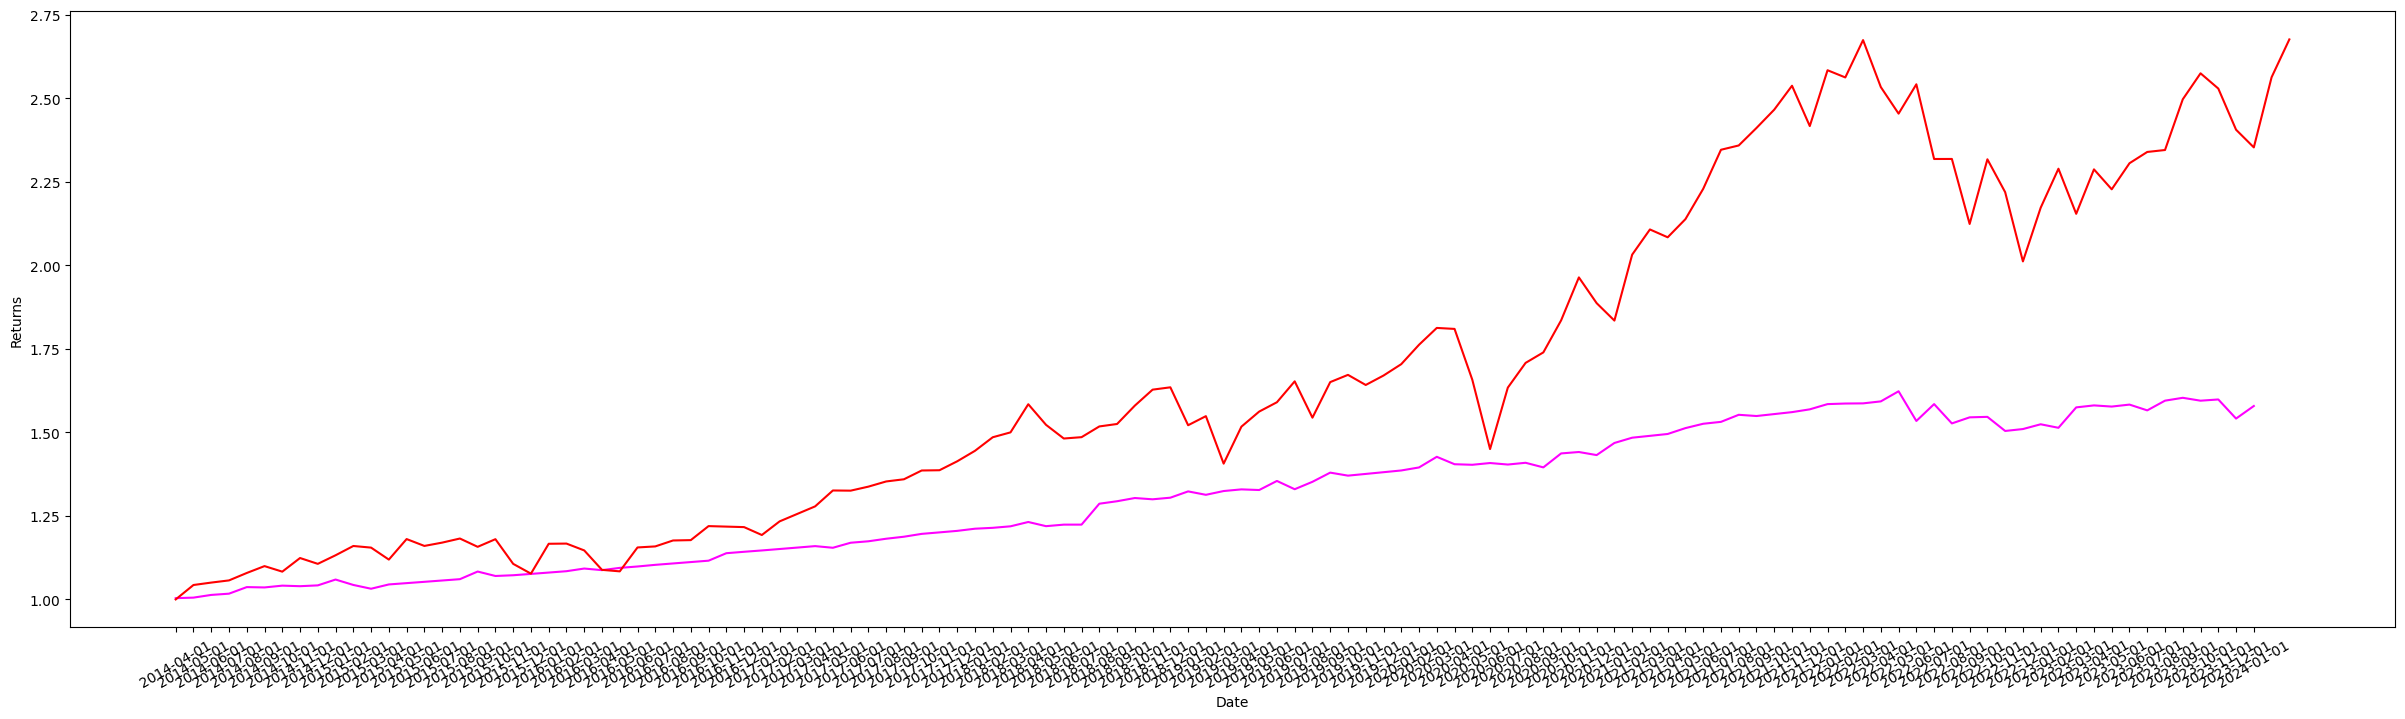

In [33]:
# Сравнение индекса и алгоритма без балансировки, бэктестинг

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[3:],
    (1 + not_rebalance_returns).cumprod(),
    color:='magenta'
)
plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod(), color:='red')
plt.show()

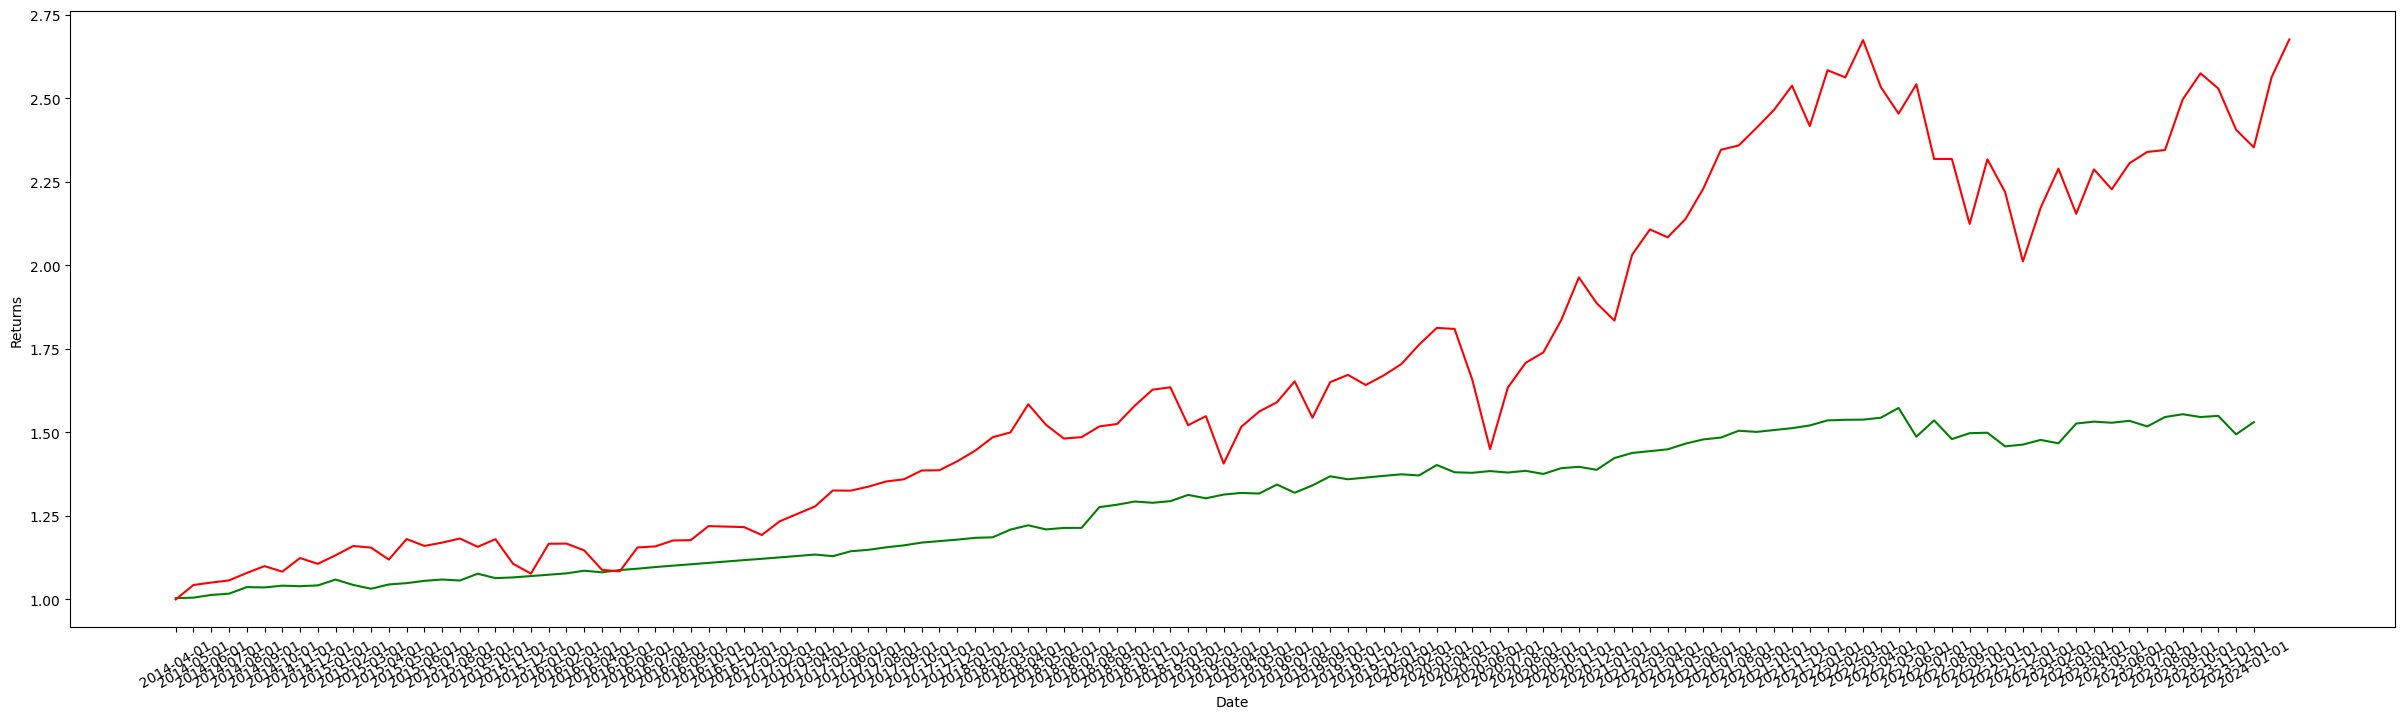

In [34]:
# Сравнение индекса и нашего алгоритма с ребалансировкой, бэктестинг

plt.figure(figsize = (30,8))
plt.xlabel('Date')
plt.ylabel('Returns')
plt.xticks(rotation=30)
plt.plot(
    dates[3:],
    (1 + returns).cumprod(),
    color:='green'
)
plt.plot((1+sp500["monthly_returns"].reset_index(drop=True)).cumprod(), color:='red')
plt.show()

## Видим, что нам не удалось перепрыгнуть S&P500, но это норм, мало кому удается его обогнать (вроде бы)